# Análisis de Datos de Fototransistores

Este cuaderno implementa un análisis completo de los datos recopilados de un arreglo de 5 fototransistores OP598 NPNs dispuestos en una protoboard. La configuración consiste en:

- 4 fototransistores en las esquinas y 1 en el centro
- Conexión en paralelo compartiendo voltaje de 3.3V
- Misma tierra del ESP32
- Resistencias de 100kΩ en cada uno
- Iluminados con un LED de 635nm

Los datos fueron recopilados con diferentes patrones de movimiento:
- Horizontal (paneoh.csv)
- Vertical (paneov.csv)
- Circular/Diagonal (paneod1.csv) 
- Aleatorio (locura.csv, locura2.csv, etc.)

La disposición espacial de los sensores, según los datos impresos durante la recolección, es:

## 1. Importación de Bibliotecas

Primero importamos las bibliotecas necesarias para el análisis:

## Configuración del Circuito

La disposición espacial de los sensores en la protoboard es la siguiente:

```
(0,1) Verde        Rojo (1,1)
              
         Amarillo (0.47,0.6)
              
(0.2,0) Azul         Naranja (0.8,0)
```

Esta disposición será utilizada en todos los análisis espaciales y visualizaciones. Las coordenadas exactas de cada sensor son:

- Azul: (0.2, 0)
- Naranja: (0.8, 0)
- Amarillo: (0.47, 0.6)
- Verde: (0, 1)
- Rojo: (1, 1)

Y la estructura del csv con los datos es:
```
tiempo,azul,verde,amarillo,naranja,rojo
```
Cuyos valores van de $0$ a $4095$.

Esto nos permite representar adecuadamente la distribución real de los sensores en el espacio, mejorando la precisión de nuestras interpretaciones.

In [1]:
# Bibliotecas para manipulación de datos
import pandas as pd
import numpy as np
import os

# Bibliotecas para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# Procesamiento de señales
from scipy.signal import find_peaks, butter, filtfilt
from scipy.interpolate import Rbf, griddata
from scipy.stats import pearsonr

# Configuración de visualización
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

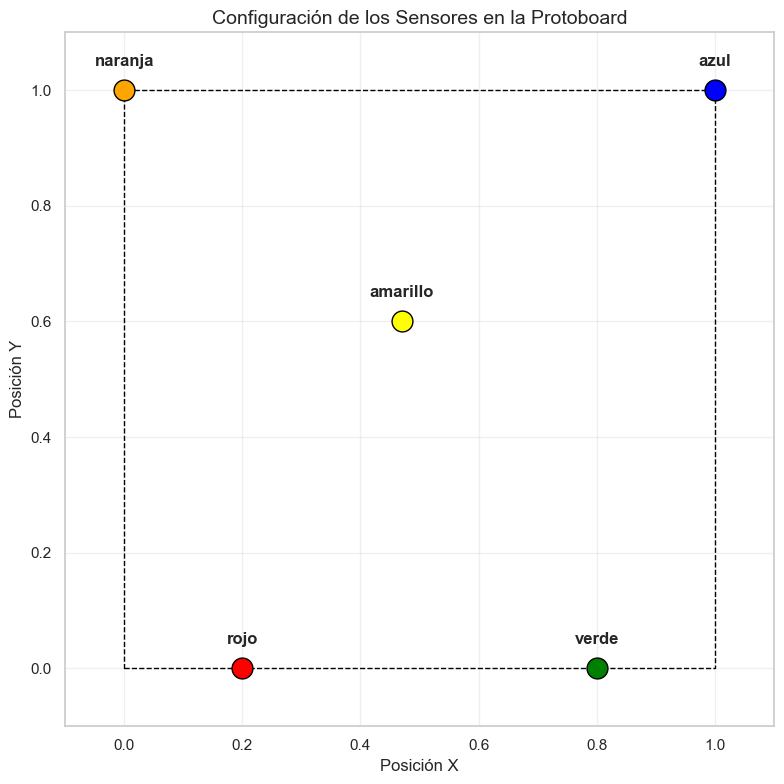

In [2]:
# Definir las posiciones de los sensores para todo el análisis
# Esta variable será utilizada por todas las funciones de visualización

# Posiciones reales de los sensores en el espacio (x, y)
POSICIONES_SENSORES = {
    'rojo': (0.2, 0),      # Esquina inferior izquierda
    'verde': (0.8, 0),     # Esquina inferior derecha
    'amarillo': (0.47, 0.6),  # Centro
    'naranja': (0, 1),   # Esquina superior izquierda
    'azul': (1, 1)       # Esquina superior derecha
}

# Orden de los sensores en los datos (como aparecen en las columnas)
ORDEN_SENSORES = ['azul', 'verde', 'amarillo', 'naranja', 'rojo']

# Crear una función auxiliar para visualizar la configuración
def visualizar_configuracion_sensores():
    """
    Muestra visualmente la configuración de los sensores en la protoboard
    """
    import matplotlib.pyplot as plt
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Dibujar el contorno de la protoboard (como un rectángulo)
    rect = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linestyle='--')
    ax.add_patch(rect)
    
    # Dibujar los sensores
    colores_reales = {
        'rojo': 'red',
        'verde': 'green',
        'amarillo': 'yellow',
        'naranja': 'orange',
        'azul': 'blue'
    }
    
    for sensor, (x, y) in POSICIONES_SENSORES.items():
        ax.plot(x, y, 'o', markersize=15, color=colores_reales[sensor], 
               markeredgecolor='black', label=sensor)
        ax.text(x, y+0.05, sensor, ha='center', va='center', fontweight='bold')
    
    # Configurar ejes
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_title('Configuración de los Sensores en la Protoboard', fontsize=14)
    ax.set_xlabel('Posición X')
    ax.set_ylabel('Posición Y')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualizar la configuración
visualizar_configuracion_sensores()

## 2. Carga y Exploración de Datos

Cargamos los archivos CSV disponibles y exploramos su estructura. Cada archivo representa un experimento diferente con distintos patrones de movimiento de la fuente de luz.

In [3]:
# Función para listar todos los archivos CSV en el directorio actual
def listar_csv():
    return [f for f in os.listdir() if f.endswith('.csv')]

# Mostrar los archivos CSV disponibles
archivos_csv = listar_csv()
print(f"Archivos CSV disponibles: {len(archivos_csv)}")
for i, archivo in enumerate(archivos_csv):
    print(f"{i+1}. {archivo}")

# Función para cargar un archivo CSV
def cargar_csv(archivo):
    df = pd.read_csv(archivo)
    
    # Verificar y adaptar los nombres de columnas si es necesario
    nombres_esperados = ['tiempo', 'azul', 'verde', 'amarillo', 'naranja', 'rojo']
    
    if list(df.columns) != nombres_esperados:
        if len(df.columns) == len(nombres_esperados):
            df.columns = nombres_esperados
            print(f"Se adaptaron los nombres de columnas para {archivo}")
        else:
            print(f"Advertencia: El archivo {archivo} tiene una estructura diferente.")
            print(f"Columnas encontradas: {list(df.columns)}")
    
    return df

# Cargar el primer archivo como ejemplo para exploración
if archivos_csv:
    df_ejemplo = cargar_csv(archivos_csv[0])
    print("\nEstructura del primer archivo:")
    print(f"Dimensiones: {df_ejemplo.shape} (filas, columnas)")
    print("\nPrimeras 5 filas:")
    print(df_ejemplo.head())
    
    print("\nEstadísticas básicas:")
    print(df_ejemplo.describe())
    
    print("\nVerificación de valores nulos:")
    print(df_ejemplo.isnull().sum())
else:
    print("No se encontraron archivos CSV en el directorio actual.")

Archivos CSV disponibles: 8
1. paneoh.csv
2. paneod1.csv
3. aaaaaaaaaaaa.csv
4. locura.csv
5. locura2.csv
6. paneov.csv
7. test1.csv
8. resultados_analisis.csv

Estructura del primer archivo:
Dimensiones: (516, 6) (filas, columnas)

Primeras 5 filas:
   tiempo  azul  verde  amarillo  naranja  rojo
0     0.0     0      0         0        0     0
1     1.0     0      0         0        0     0
2     1.0     0      0         0        0     0
3     1.0     0      0         0        0     0
4     1.0     0      0         0        0     0

Estadísticas básicas:
           tiempo        azul       verde    amarillo     naranja        rojo
count  516.000000  516.000000  516.000000  516.000000  516.000000  516.000000
mean    46.581395   45.122093   42.523256   51.323643   41.509690   14.994186
std     27.491343   99.576885  127.770947  105.653445  103.570106   50.769439
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
25%     22.000000    0.000000    0.000000    0.0

## 3. Preprocesamiento de Datos

Ahora preprocesamos los datos para facilitar el análisis. Esto incluye:
- Normalización de las señales
- Cálculo de derivadas (tasas de cambio)
- Aplicación de filtros para reducir ruido

In [4]:
class ProcesadorFototransistores:
    def __init__(self, archivo):
        """Inicializa el procesador con un archivo CSV"""
        self.archivo = archivo
        self.df_original = cargar_csv(archivo)
        self.df = self.df_original.copy()
        
        # Normalizar datos entre 0 y 1 para mejor visualización
        self.normalizar_datos()
        
        # Calcular tasas de cambio (derivadas)
        self.calcular_derivadas()
        
        # Aplicar filtro de suavizado
        self.aplicar_filtro()
        
    def normalizar_datos(self):
        """Normaliza los datos de cada sensor entre 0 y 1"""
        for columna in self.df.columns[1:]:  # Todas menos 'tiempo'
            max_val = self.df[columna].max()
            min_val = self.df[columna].min()
            rango = max_val - min_val
            
            if rango > 0:  # Evitar división por cero
                self.df[f'{columna}_norm'] = (self.df[columna] - min_val) / rango
            else:
                self.df[f'{columna}_norm'] = 0
                print(f"Advertencia: Sensor {columna} no muestra variación")
    
    def calcular_derivadas(self):
        """Calcula las tasas de cambio (derivadas) de las señales"""
        for columna in self.df.columns[1:6]:  # Solo los sensores originales
            # Derivada respecto al tiempo
            self.df[f'{columna}_delta'] = self.df[columna].diff() / self.df['tiempo'].diff()
            
            # Reemplazar infinitos o NaNs con 0
            self.df[f'{columna}_delta'].fillna(0, inplace=True)
            self.df[f'{columna}_delta'].replace([np.inf, -np.inf], 0, inplace=True)
    
    def aplicar_filtro(self, frecuencia_corte=0.1, orden=3):
        """Aplica un filtro paso bajo para suavizar las señales"""
        # Parámetros del filtro Butterworth
        b, a = butter(orden, frecuencia_corte, 'low')
        
        # Aplicar el filtro a cada sensor
        for columna in self.df.columns[1:6]:  # Solo los sensores originales
            # Verificar que hay suficientes puntos para aplicar el filtro
            if len(self.df) > orden + 1:
                self.df[f'{columna}_filtrado'] = filtfilt(b, a, self.df[columna])
            else:
                self.df[f'{columna}_filtrado'] = self.df[columna]
                print(f"Advertencia: Datos insuficientes para filtrar {columna}")
    
    def obtener_dataframe_procesado(self):
        """Devuelve el dataframe procesado"""
        return self.df

# Demostración con un archivo
if archivos_csv:
    archivo_demo = archivos_csv[0]
    procesador = ProcesadorFototransistores(archivo_demo)
    df_procesado = procesador.obtener_dataframe_procesado()
    
    print(f"Columnas después del procesamiento para {archivo_demo}:")
    print(df_procesado.columns.tolist())
    
    # Mostrar algunas filas del dataframe procesado
    print("\nPrimeras 3 filas del dataframe procesado:")
    print(df_procesado.head(3))

Columnas después del procesamiento para paneoh.csv:
['tiempo', 'azul', 'verde', 'amarillo', 'naranja', 'rojo', 'azul_norm', 'verde_norm', 'amarillo_norm', 'naranja_norm', 'rojo_norm', 'azul_delta', 'verde_delta', 'amarillo_delta', 'naranja_delta', 'rojo_delta', 'azul_filtrado', 'verde_filtrado', 'amarillo_filtrado', 'naranja_filtrado', 'rojo_filtrado']

Primeras 3 filas del dataframe procesado:
   tiempo  azul  verde  amarillo  naranja  rojo  azul_norm  verde_norm  \
0     0.0     0      0         0        0     0        0.0         0.0   
1     1.0     0      0         0        0     0        0.0         0.0   
2     1.0     0      0         0        0     0        0.0         0.0   

   amarillo_norm  naranja_norm  ...  azul_delta  verde_delta  amarillo_delta  \
0            0.0           0.0  ...         0.0          0.0             0.0   
1            0.0           0.0  ...         0.0          0.0             0.0   
2            0.0           0.0  ...         0.0          0.0     

## 4. Visualización de Datos Crudos

Visualizamos los datos crudos para entender mejor las señales de los fototransistores:

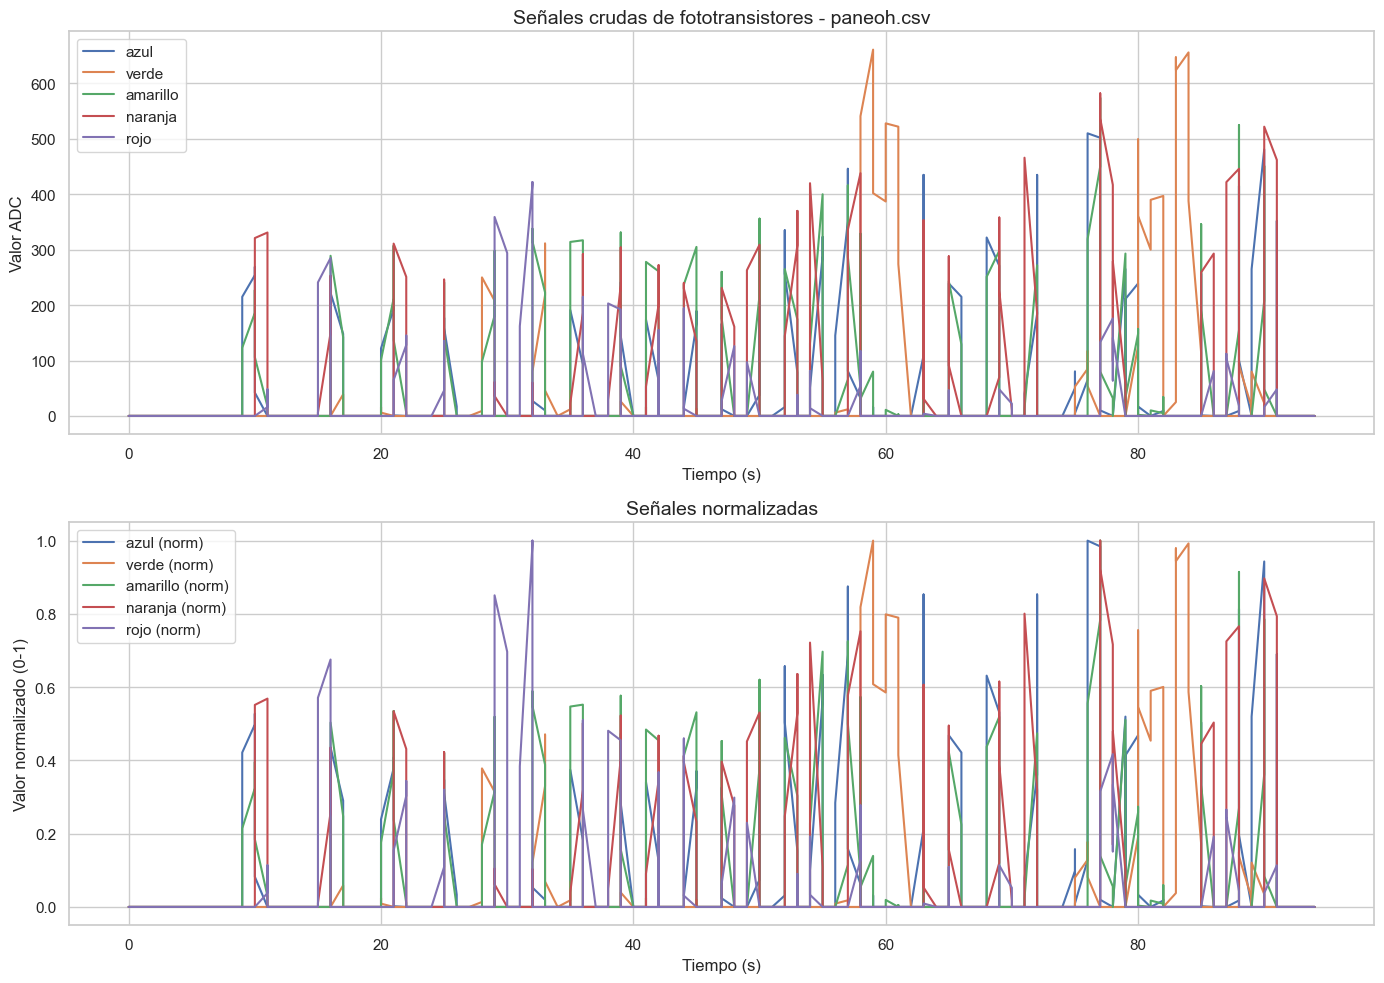

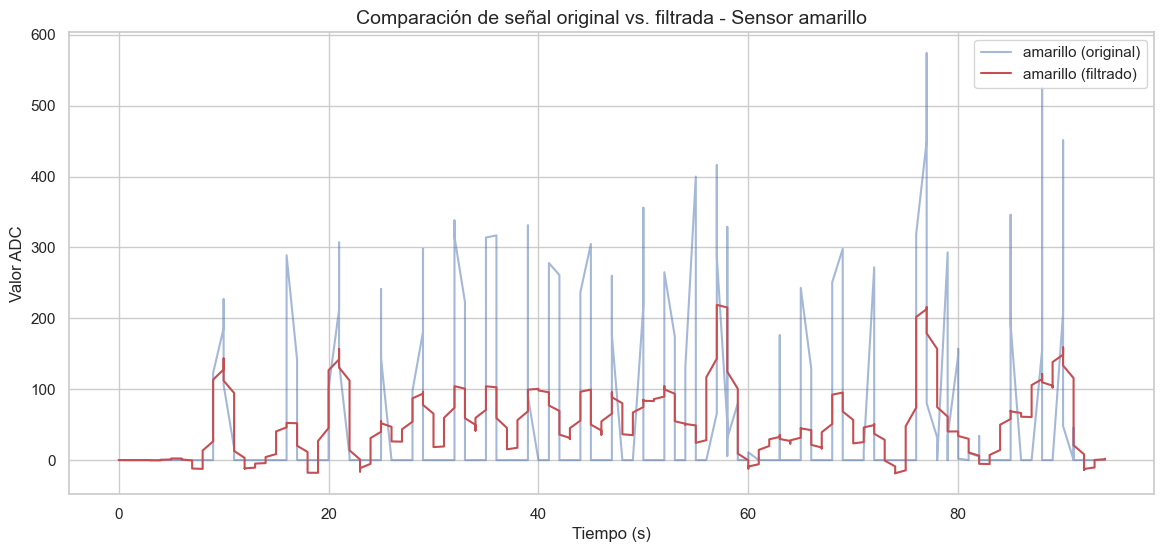

In [5]:
def visualizar_datos_crudos(archivo):
    """
    Crea visualizaciones de las señales crudas de los fototransistores
    """
    # Cargar y procesar los datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Crear figura con subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # 1. Gráfico de series temporales para datos crudos
    ax = axes[0]
    sensores = ['azul', 'verde', 'amarillo', 'naranja', 'rojo']
    for sensor in sensores:
        ax.plot(df['tiempo'], df[sensor], label=sensor)
    
    ax.set_title(f'Señales crudas de fototransistores - {os.path.basename(archivo)}', fontsize=14)
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Valor ADC')
    ax.legend()
    ax.grid(True)
    
    # 2. Gráfico de señales normalizadas
    ax = axes[1]
    for sensor in sensores:
        ax.plot(df['tiempo'], df[f'{sensor}_norm'], label=f'{sensor} (norm)')
    
    ax.set_title('Señales normalizadas', fontsize=14)
    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Valor normalizado (0-1)')
    ax.legend()
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Gráfico de señales filtradas vs. originales para un sensor
    # Elegimos el sensor 'amarillo' (central) como ejemplo
    sensor_ejemplo = 'amarillo'
    
    plt.figure(figsize=(14, 6))
    plt.plot(df['tiempo'], df[sensor_ejemplo], 'b-', alpha=0.5, label=f'{sensor_ejemplo} (original)')
    plt.plot(df['tiempo'], df[f'{sensor_ejemplo}_filtrado'], 'r-', 
             label=f'{sensor_ejemplo} (filtrado)')
    
    plt.title(f'Comparación de señal original vs. filtrada - Sensor {sensor_ejemplo}', fontsize=14)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Valor ADC')
    plt.legend()
    plt.grid(True)
    plt.show()

# Demostrar la visualización con un archivo de ejemplo
if archivos_csv:
    visualizar_datos_crudos(archivos_csv[0])

## 5. Análisis de Señales de Fototransistores

Ahora analizamos las señales para extraer información sobre los patrones de movimiento:
- Análisis de correlación entre sensores
- Detección de picos
- Análisis de fase para identificar patrones de movimiento

Análisis de correlaciones para paneoh.csv:


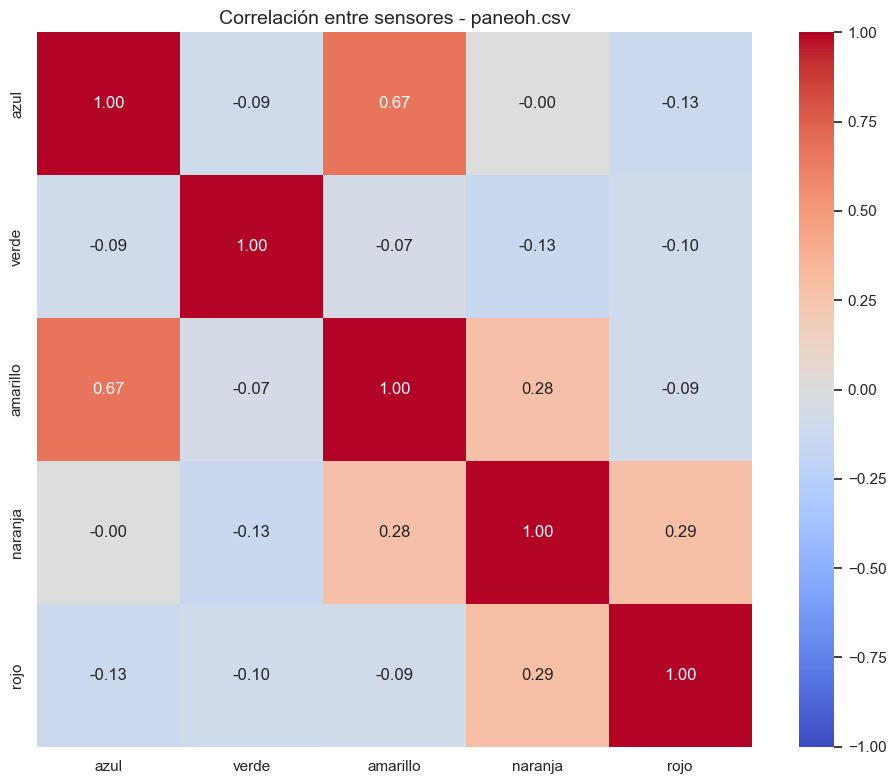

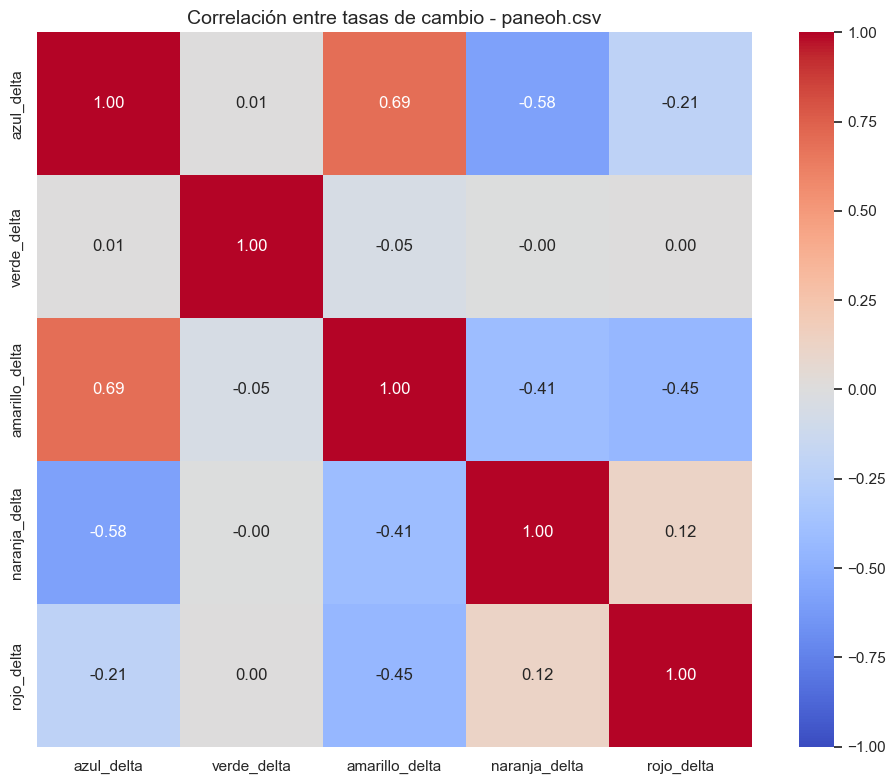


Detección de picos para paneoh.csv:


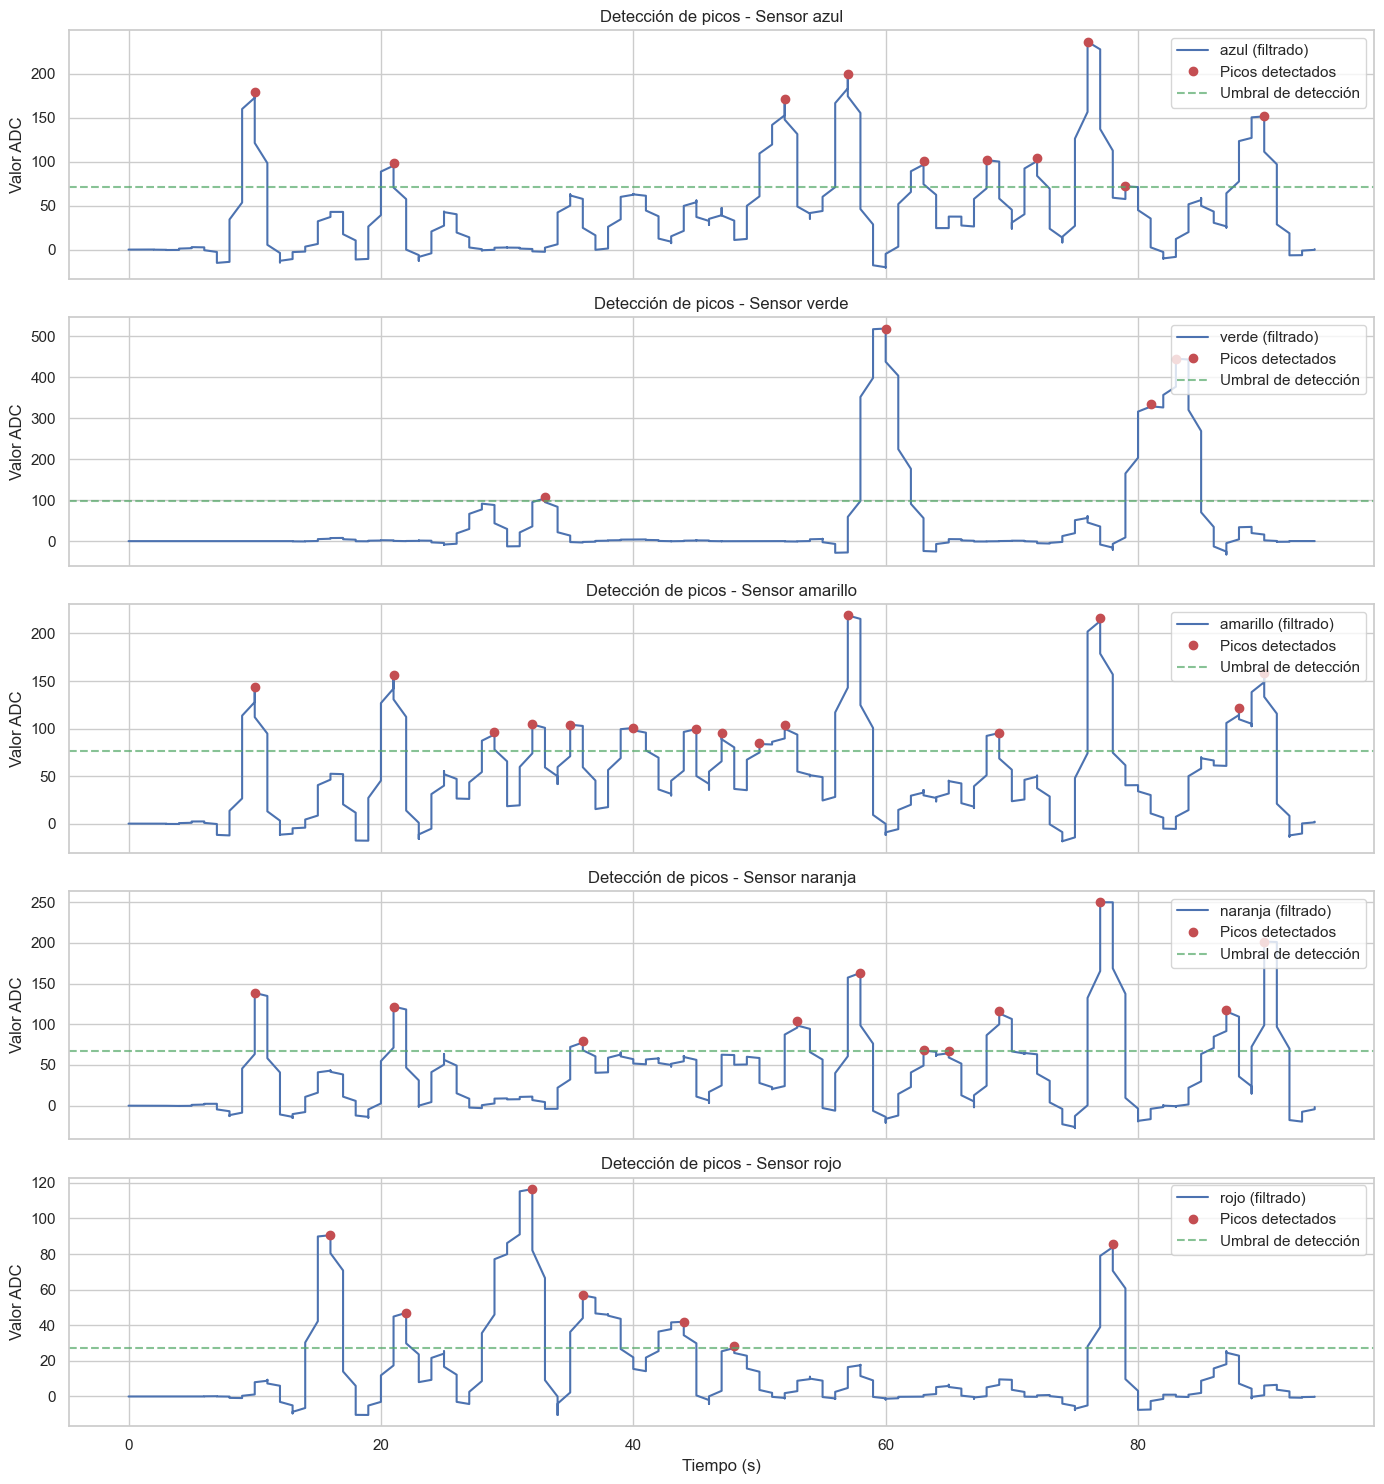

In [6]:
def analizar_correlaciones(archivo):
    """
    Analiza las correlaciones entre las señales de los fototransistores
    """
    # Cargar y procesar los datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Calcular matriz de correlación entre sensores
    sensores = ['azul', 'verde', 'amarillo', 'naranja', 'rojo']
    matriz_corr = df[sensores].corr()
    
    # Visualizar la matriz de correlación
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                square=True, fmt='.2f')
    plt.title(f'Correlación entre sensores - {os.path.basename(archivo)}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Correlación entre derivadas (tasas de cambio)
    sensores_delta = [f'{sensor}_delta' for sensor in sensores]
    matriz_corr_delta = df[sensores_delta].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_corr_delta, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                square=True, fmt='.2f')
    plt.title(f'Correlación entre tasas de cambio - {os.path.basename(archivo)}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return matriz_corr, matriz_corr_delta

def detectar_picos(archivo):
    """
    Detecta picos en las señales de los fototransistores
    """
    # Cargar y procesar los datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Configurar figura
    fig, axes = plt.subplots(5, 1, figsize=(14, 15), sharex=True)
    
    sensores = ['azul', 'verde', 'amarillo', 'naranja', 'rojo']
    resultados_picos = {}
    
    for i, sensor in enumerate(sensores):
        # Usar la señal filtrada para mejor detección de picos
        señal = df[f'{sensor}_filtrado']
        
        # Encontrar picos (máximos locales)
        # Ajustar parámetros según necesidad
        altura_min = np.mean(señal) + 0.5 * np.std(señal)  # Umbral adaptativo
        distancia_min = max(5, len(df) // 50)  # Distancia mínima entre picos
        
        indices_picos, _ = find_peaks(señal, height=altura_min, distance=distancia_min)
        tiempos_picos = df['tiempo'].iloc[indices_picos].values
        valores_picos = señal.iloc[indices_picos].values
        
        # Guardar resultados
        resultados_picos[sensor] = {
            'indices': indices_picos,
            'tiempos': tiempos_picos,
            'valores': valores_picos
        }
        
        # Graficar
        ax = axes[i]
        ax.plot(df['tiempo'], señal, label=f'{sensor} (filtrado)')
        ax.plot(tiempos_picos, valores_picos, 'ro', label='Picos detectados')
        ax.axhline(y=altura_min, color='g', linestyle='--', alpha=0.7, 
                  label='Umbral de detección')
        
        ax.set_title(f'Detección de picos - Sensor {sensor}')
        ax.set_ylabel('Valor ADC')
        ax.legend(loc='upper right')
        ax.grid(True)
    
    axes[-1].set_xlabel('Tiempo (s)')
    plt.tight_layout()
    plt.show()
    
    return resultados_picos

# Demostrar el análisis con un archivo de ejemplo
if archivos_csv:
    print(f"Análisis de correlaciones para {archivos_csv[0]}:")
    matriz_corr, matriz_corr_delta = analizar_correlaciones(archivos_csv[0])
    
    print(f"\nDetección de picos para {archivos_csv[0]}:")
    resultados_picos = detectar_picos(archivos_csv[0])

## 6. Filtrado de Ruido

Implementamos técnicas más avanzadas para filtrar el ruido y mejorar la calidad de las señales.

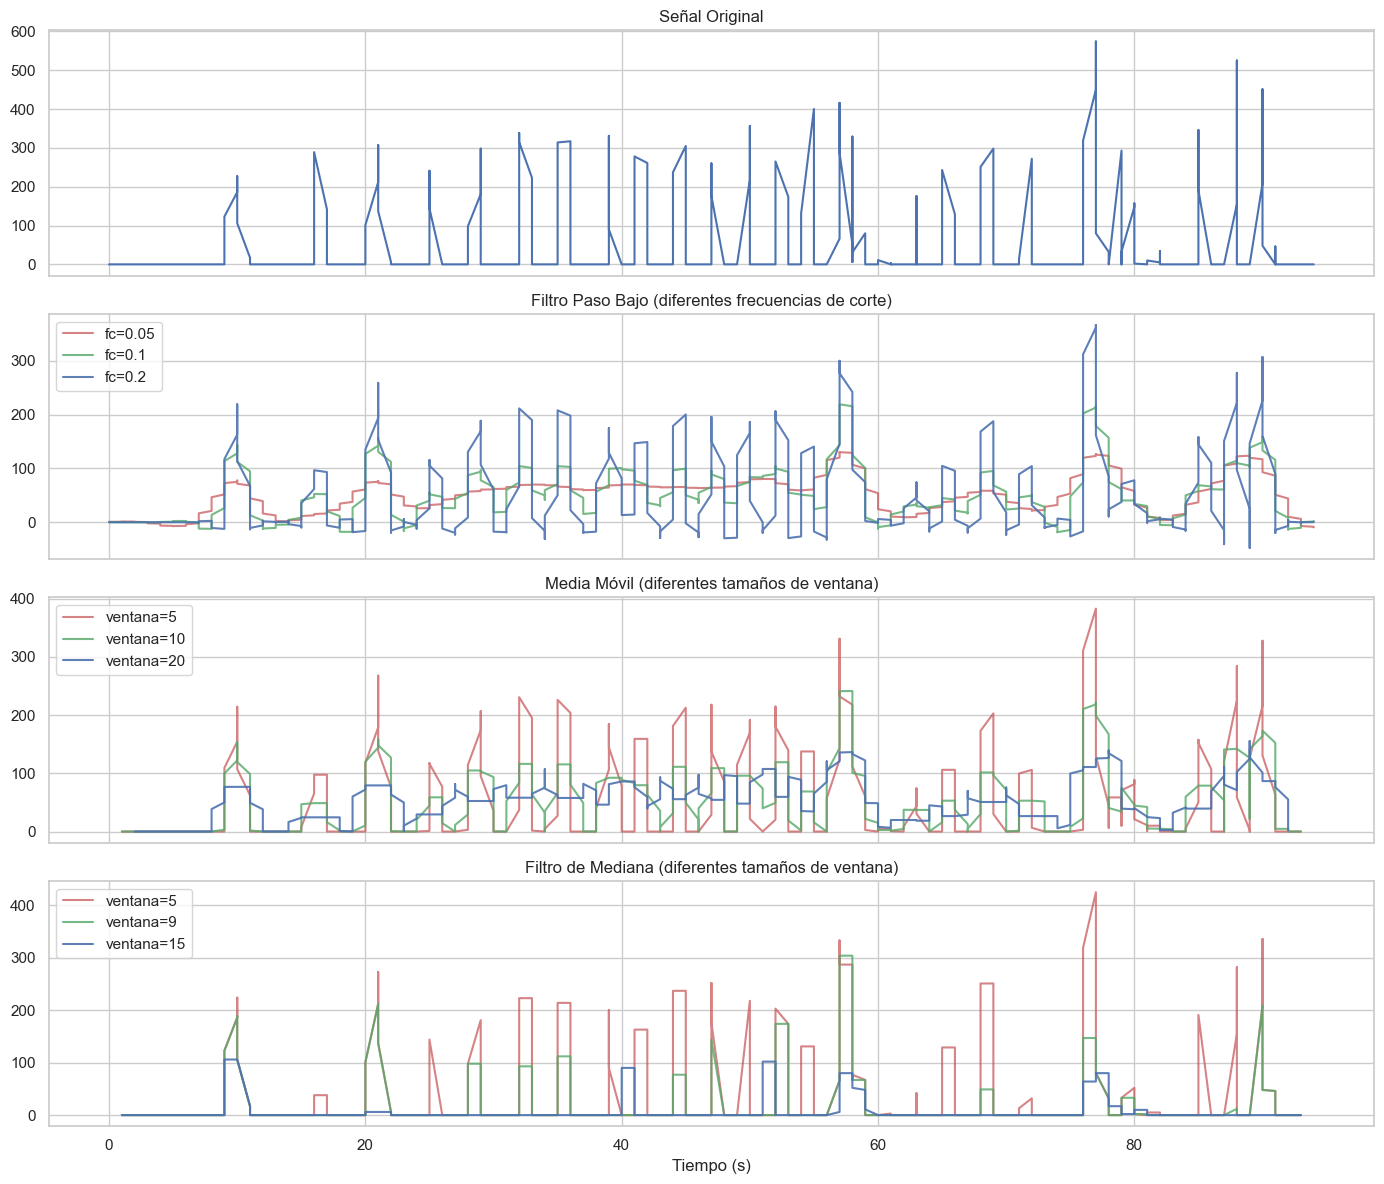

In [7]:
def aplicar_filtros_avanzados(archivo):
    """
    Aplica diferentes tipos de filtros a las señales y compara los resultados
    """
    # Cargar datos originales
    df_original = cargar_csv(archivo)
    
    # Sensor de ejemplo (centro)
    sensor = 'amarillo'
    
    # Crear figura
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)
    
    # 1. Señal original
    axes[0].plot(df_original['tiempo'], df_original[sensor])
    axes[0].set_title('Señal Original')
    axes[0].grid(True)
    
    # 2. Filtro paso bajo (diferentes frecuencias de corte)
    for fc, color, alpha in zip([0.05, 0.1, 0.2], ['r', 'g', 'b'], [0.7, 0.8, 0.9]):
        # Parámetros del filtro
        orden = 3
        b, a = butter(orden, fc, 'low')
        
        # Aplicar filtro
        señal_filtrada = filtfilt(b, a, df_original[sensor])
        
        # Graficar
        axes[1].plot(df_original['tiempo'], señal_filtrada, color=color, alpha=alpha,
                    label=f'fc={fc}')
    
    axes[1].set_title('Filtro Paso Bajo (diferentes frecuencias de corte)')
    axes[1].legend()
    axes[1].grid(True)
    
    # 3. Media móvil (diferentes ventanas)
    for ventana, color, alpha in zip([5, 10, 20], ['r', 'g', 'b'], [0.7, 0.8, 0.9]):
        # Aplicar media móvil
        señal_filtrada = df_original[sensor].rolling(window=ventana, center=True).mean()
        
        # Graficar
        axes[2].plot(df_original['tiempo'], señal_filtrada, color=color, alpha=alpha,
                    label=f'ventana={ventana}')
    
    axes[2].set_title('Media Móvil (diferentes tamaños de ventana)')
    axes[2].legend()
    axes[2].grid(True)
    
    # 4. Filtro de mediana (útil para eliminar outliers)
    for ventana, color, alpha in zip([5, 9, 15], ['r', 'g', 'b'], [0.7, 0.8, 0.9]):
        # Aplicar filtro de mediana
        señal_filtrada = df_original[sensor].rolling(window=ventana, center=True).median()
        
        # Graficar
        axes[3].plot(df_original['tiempo'], señal_filtrada, color=color, alpha=alpha,
                    label=f'ventana={ventana}')
    
    axes[3].set_title('Filtro de Mediana (diferentes tamaños de ventana)')
    axes[3].legend()
    axes[3].grid(True)
    axes[3].set_xlabel('Tiempo (s)')
    
    plt.tight_layout()
    plt.show()

# Demostrar el filtrado con un archivo de ejemplo
if archivos_csv:
    aplicar_filtros_avanzados(archivos_csv[0])

## 7. Detección de Picos y Eventos

Implementamos algoritmos para detectar picos y eventos significativos en las señales.

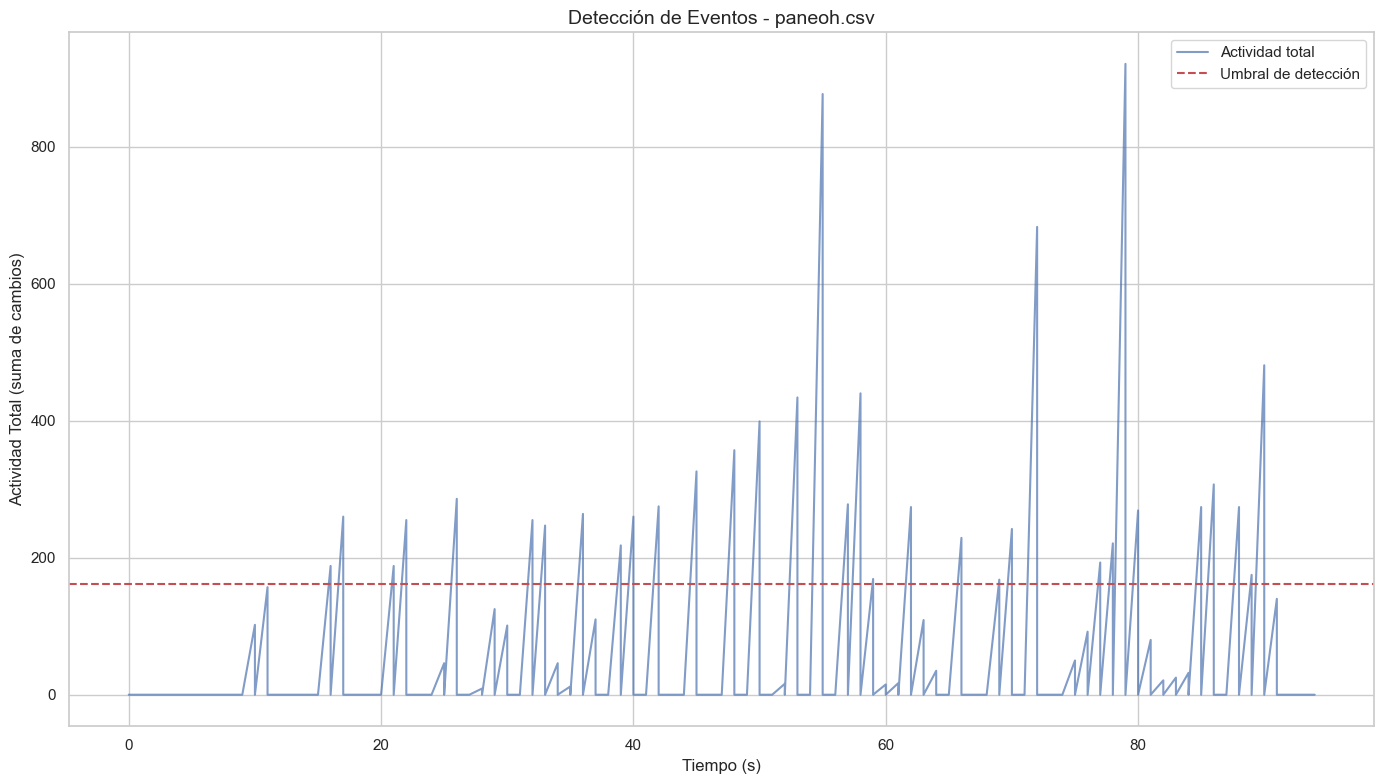

Se detectaron 0 eventos significativos


In [8]:
def analizar_eventos(archivo):
    """
    Detecta y analiza eventos significativos en las señales
    """
    # Cargar y procesar datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Definimos un evento como un cambio significativo en la intensidad
    # detectada por cualquiera de los sensores
    
    # 1. Calcular la suma de las derivadas absolutas como indicador de actividad
    df['actividad_total'] = 0
    for sensor in ['azul', 'verde', 'amarillo', 'naranja', 'rojo']:
        df['actividad_total'] += np.abs(df[f'{sensor}_delta'])
    
    # 2. Detectar eventos cuando la actividad supera un umbral
    umbral_actividad = df['actividad_total'].mean() + 1.5 * df['actividad_total'].std()
    df['es_evento'] = df['actividad_total'] > umbral_actividad
    
    # 3. Agrupar eventos consecutivos
    df['grupo_evento'] = (df['es_evento'] != df['es_evento'].shift()).cumsum()
    eventos = []
    
    for grupo in df[df['es_evento']]['grupo_evento'].unique():
        grupo_df = df[df['grupo_evento'] == grupo]
        if grupo_df['es_evento'].any():
            inicio = grupo_df['tiempo'].iloc[0]
            fin = grupo_df['tiempo'].iloc[-1]
            duracion = fin - inicio
            intensidad_max = grupo_df['actividad_total'].max()
            
            # Solo considerar eventos con duración significativa
            if duracion > 0.1:  # Eventos de al menos 0.1 segundos
                eventos.append({
                    'inicio': inicio,
                    'fin': fin,
                    'duracion': duracion,
                    'intensidad_max': intensidad_max
                })
    
    # 4. Visualizar eventos detectados
    plt.figure(figsize=(14, 8))
    
    # Graficar la actividad total
    plt.plot(df['tiempo'], df['actividad_total'], 'b-', alpha=0.7, label='Actividad total')
    
    # Marcar el umbral
    plt.axhline(y=umbral_actividad, color='r', linestyle='--', 
               label='Umbral de detección')
    
    # Sombrear las regiones de eventos
    for evento in eventos:
        plt.axvspan(evento['inicio'], evento['fin'], alpha=0.3, color='green')
        
        # Anotar el evento con su duración
        posicion_x = (evento['inicio'] + evento['fin']) / 2
        posicion_y = umbral_actividad * 1.1
        plt.annotate(f"{evento['duracion']:.2f}s", 
                    (posicion_x, posicion_y),
                    ha='center', va='bottom',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))
    
    plt.title(f'Detección de Eventos - {os.path.basename(archivo)}', fontsize=14)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Actividad Total (suma de cambios)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # 5. Mostrar resumen de eventos
    print(f"Se detectaron {len(eventos)} eventos significativos")
    if eventos:
        eventos_df = pd.DataFrame(eventos)
        print("\nResumen de eventos:")
        print(eventos_df)
    
    return eventos

# Demostrar el análisis de eventos con un archivo de ejemplo
if archivos_csv:
    eventos = analizar_eventos(archivos_csv[0])

## 8. Análisis Estadístico

Realizamos un análisis estadístico más detallado para caracterizar el comportamiento de los sensores.

Estadísticas descriptivas avanzadas:
                 azul       verde    amarillo     naranja        rojo
media       45.122093   42.523256   51.323643   41.509690   14.994186
mediana      0.000000    0.000000    0.000000    0.000000    0.000000
desv_std    99.576885  127.770947  105.653445  103.570106   50.769439
min          0.000000    0.000000    0.000000    0.000000    0.000000
max        510.000000  661.000000  574.000000  582.000000  422.000000
rango      510.000000  661.000000  574.000000  582.000000  422.000000
iqr         14.000000    0.000000   20.000000    0.000000    0.000000
asimetria    2.444452    3.219029    2.160288    2.718220    4.571434
curtosis     5.508609    9.489597    4.051557    6.934648   24.913180


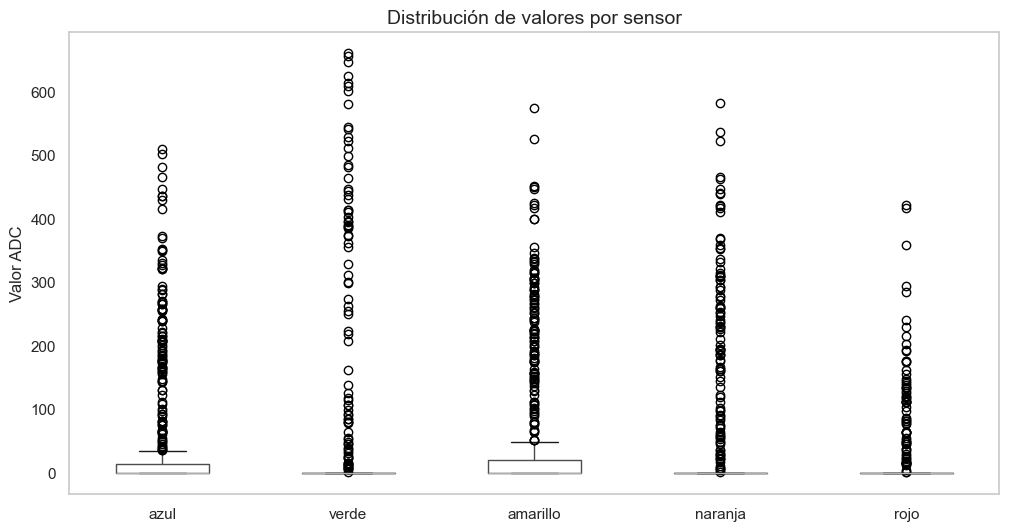


Análisis de Varianza (ANOVA):
F-valor: 9.9762
p-valor: 0.0000
Conclusión: Existen diferencias significativas entre los sensores (p < 0.05)

Comparaciones por pares (pruebas t):
azul vs verde: p-valor = 0.7156 (No significativo)
azul vs amarillo: p-valor = 0.3321 (No significativo)
azul vs naranja: p-valor = 0.5680 (No significativo)
azul vs rojo: p-valor = 0.0000 (Significativo)
verde vs amarillo: p-valor = 0.2282 (No significativo)
verde vs naranja: p-valor = 0.8887 (No significativo)
verde vs rojo: p-valor = 0.0000 (Significativo)
amarillo vs naranja: p-valor = 0.1322 (No significativo)
amarillo vs rojo: p-valor = 0.0000 (Significativo)
naranja vs rojo: p-valor = 0.0000 (Significativo)


In [9]:
def analisis_estadistico_avanzado(archivo):
    """
    Realiza un análisis estadístico avanzado de las señales
    """
    # Cargar y procesar datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    sensores = ['azul', 'verde', 'amarillo', 'naranja', 'rojo']
    
    # 1. Estadísticas descriptivas avanzadas
    stats = {}
    for sensor in sensores:
        stats[sensor] = {
            'media': df[sensor].mean(),
            'mediana': df[sensor].median(),
            'desv_std': df[sensor].std(),
            'min': df[sensor].min(),
            'max': df[sensor].max(),
            'rango': df[sensor].max() - df[sensor].min(),
            'iqr': df[sensor].quantile(0.75) - df[sensor].quantile(0.25),
            'asimetria': df[sensor].skew(),
            'curtosis': df[sensor].kurtosis()
        }
    
    # Convertir a DataFrame para mejor visualización
    stats_df = pd.DataFrame(stats)
    
    print("Estadísticas descriptivas avanzadas:")
    print(stats_df)
    
    # 2. Gráfico de caja para comparar distribuciones
    plt.figure(figsize=(12, 6))
    df[sensores].boxplot()
    plt.title('Distribución de valores por sensor', fontsize=14)
    plt.ylabel('Valor ADC')
    plt.grid(False)
    plt.show()
    
    # 3. Análisis de varianza para determinar diferencias significativas
    from scipy import stats as scistat
    
    # Preparar datos para ANOVA
    valores_por_sensor = [df[sensor].values for sensor in sensores]
    
    # Realizar ANOVA
    f_val, p_val = scistat.f_oneway(*valores_por_sensor)
    
    print(f"\nAnálisis de Varianza (ANOVA):")
    print(f"F-valor: {f_val:.4f}")
    print(f"p-valor: {p_val:.4f}")
    
    if p_val < 0.05:
        print("Conclusión: Existen diferencias significativas entre los sensores (p < 0.05)")
    else:
        print("Conclusión: No hay diferencias significativas entre los sensores (p >= 0.05)")
    
    # 4. Pruebas post-hoc para determinar qué sensores difieren (si ANOVA es significativo)
    if p_val < 0.05:
        print("\nComparaciones por pares (pruebas t):")
        for i, sensor1 in enumerate(sensores):
            for sensor2 in sensores[i+1:]:
                t_val, p_val_t = scistat.ttest_ind(df[sensor1], df[sensor2], equal_var=False)
                sig = "Significativo" if p_val_t < 0.05 else "No significativo"
                print(f"{sensor1} vs {sensor2}: p-valor = {p_val_t:.4f} ({sig})")
    
    return stats_df

# Demostrar el análisis estadístico con un archivo de ejemplo
if archivos_csv:
    stats_df = analisis_estadistico_avanzado(archivos_csv[0])

## 9. Visualización de Resultados

Creamos visualizaciones avanzadas para entender mejor el comportamiento de los fototransistores y los patrones de movimiento de la luz.

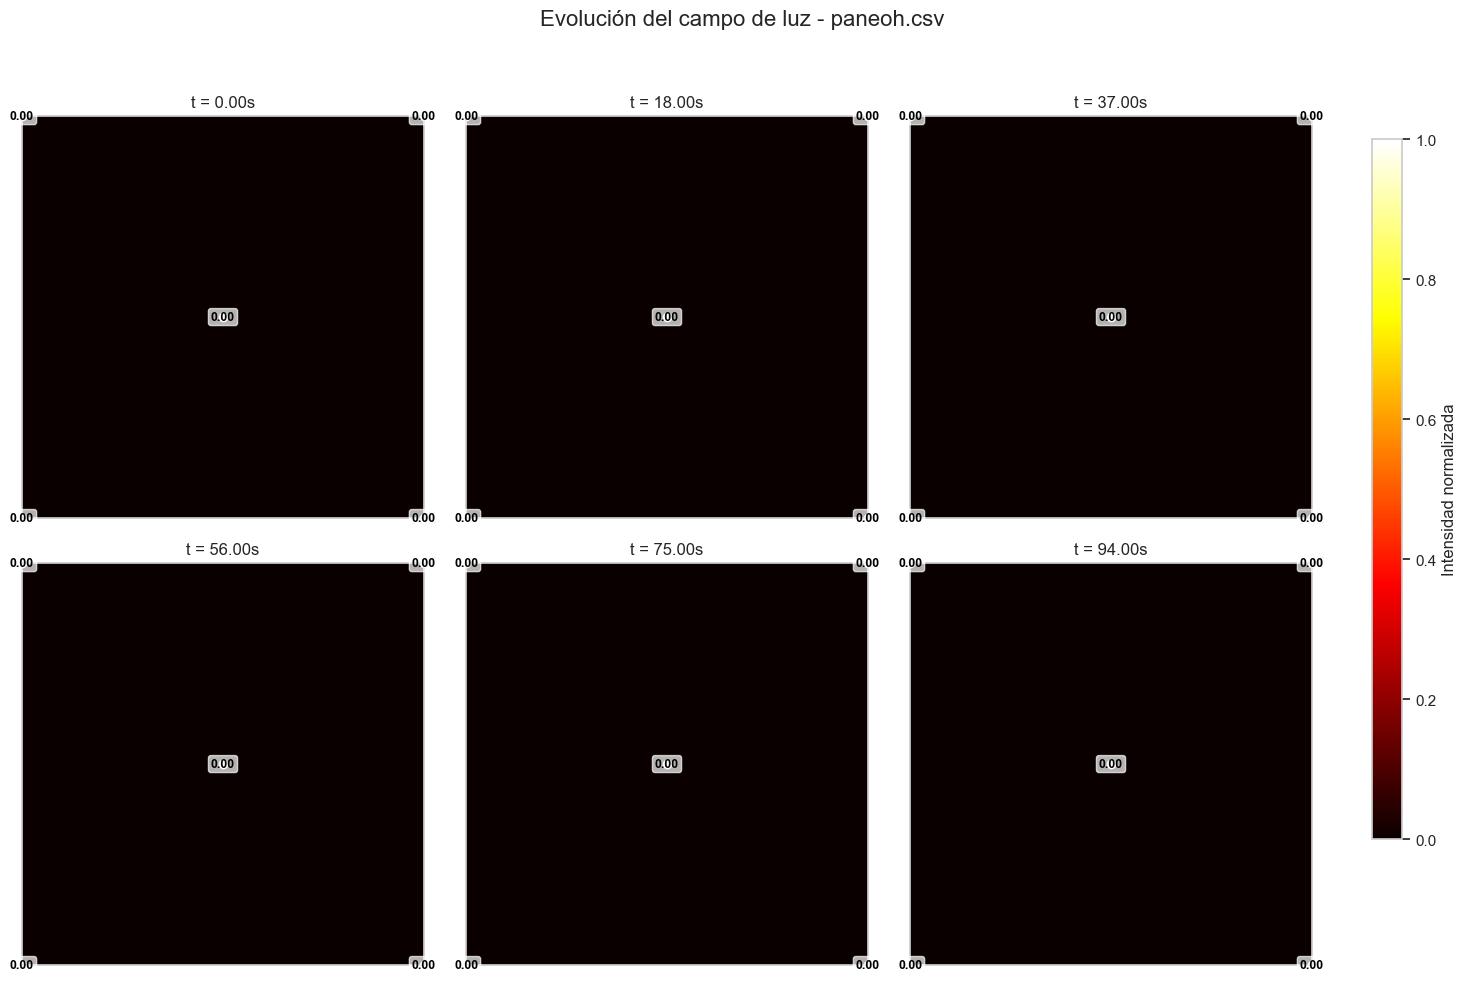

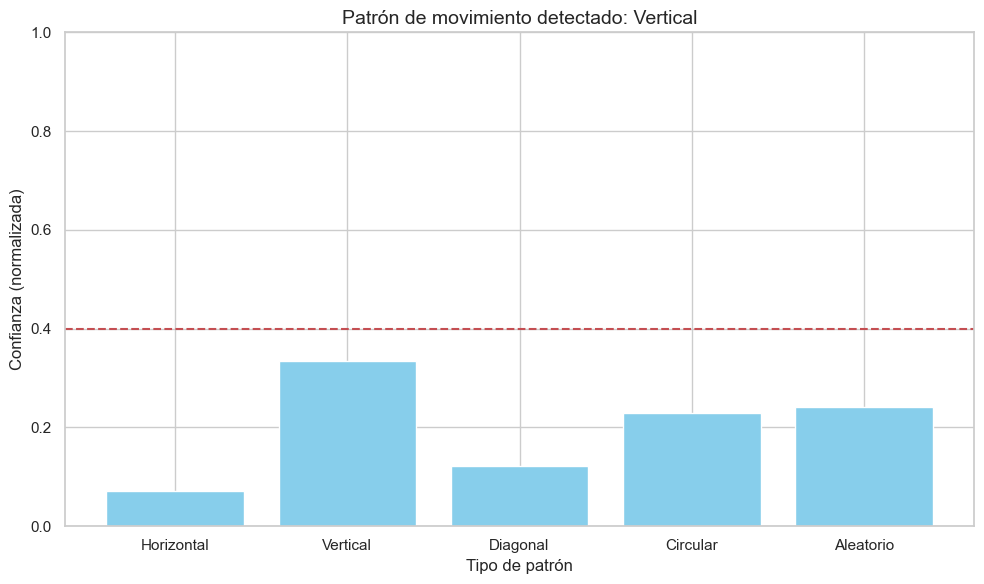

Análisis de patrón para paneoh.csv:
Patrón más probable: Vertical
Confianza por patrón:
  Vertical: 0.33
  Aleatorio: 0.24
  Circular: 0.23
  Diagonal: 0.12
  Horizontal: 0.07


In [10]:
def visualizar_mapa_calor_luz(archivo):
    """
    Crea una visualización del campo de luz usando interpolación espacial
    """
    # Cargar y procesar datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Posiciones de los sensores en el espacio (x, y)
    posiciones = {
        'azul': (0, 0),      # Esquina superior izquierda
        'verde': (1, 0),     # Esquina superior derecha
        'amarillo': (0.5, 0.5),  # Centro
        'naranja': (0, 1),   # Esquina inferior izquierda
        'rojo': (1, 1)       # Esquina inferior derecha
    }
    
    # Configurar la figura con subplots para diferentes momentos
    num_frames = min(6, len(df))
    indices = np.linspace(0, len(df) - 1, num_frames, dtype=int)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Crear una cuadrícula para la interpolación
    grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
    
    # Para cada momento, crear un mapa de calor
    for i, idx in enumerate(indices):
        if i < len(axes):
            ax = axes[i]
            
            # Valores normalizados para este instante
            valores = [df.iloc[idx][f'{sensor}_norm'] for sensor in posiciones.keys()]
            puntos = np.array(list(posiciones.values()))
            
            # Interpolar usando Radial Basis Function
            rbf = Rbf(puntos[:, 0], puntos[:, 1], valores, function='multiquadric')
            z = rbf(grid_x, grid_y)
            
            # Graficar el mapa de calor
            im = ax.imshow(z.T, origin='lower', extent=[0, 1, 0, 1], 
                          cmap='hot', vmin=0, vmax=1)
            
            # Marcar posiciones de los sensores
            for sensor, (x, y) in posiciones.items():
                valor = df.iloc[idx][f'{sensor}_norm']
                ax.plot(x, y, 'o', markersize=8, 
                       markerfacecolor='white', markeredgecolor='black')
                ax.text(x, y, f'{valor:.2f}', ha='center', va='center', 
                       fontsize=9, color='black', fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
            
            ax.set_title(f't = {df.iloc[idx]["tiempo"]:.2f}s')
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Añadir una barra de color
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Intensidad normalizada')
    
    plt.suptitle(f'Evolución del campo de luz - {os.path.basename(archivo)}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()
    
    return

def detectar_patron_movimiento(archivo):
    """
    Detecta el patrón de movimiento de la luz a partir de las correlaciones
    """
    # Cargar y procesar datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Calcular correlaciones entre tasas de cambio (derivadas)
    sensores = ['azul', 'verde', 'amarillo', 'naranja', 'rojo']
    sensores_delta = [f'{sensor}_delta' for sensor in sensores]
    matriz_corr_delta = df[sensores_delta].corr()
    
    # Analizar patrones basados en correlaciones
    # Definir umbrales
    umbral_correlacion = 0.6
    
    # 1. Verificar correlaciones horizontales
    corr_horiz_1 = abs(matriz_corr_delta.loc['azul_delta', 'verde_delta'])
    corr_horiz_2 = abs(matriz_corr_delta.loc['naranja_delta', 'rojo_delta'])
    
    # 2. Verificar correlaciones verticales
    corr_vert_1 = abs(matriz_corr_delta.loc['azul_delta', 'naranja_delta'])
    corr_vert_2 = abs(matriz_corr_delta.loc['verde_delta', 'rojo_delta'])
    
    # 3. Verificar correlaciones diagonales
    corr_diag_1 = abs(matriz_corr_delta.loc['azul_delta', 'rojo_delta'])
    corr_diag_2 = abs(matriz_corr_delta.loc['verde_delta', 'naranja_delta'])
    
    # 4. Verificar correlaciones con el centro
    corr_centro = [
        abs(matriz_corr_delta.loc['amarillo_delta', sensor]) 
        for sensor in sensores_delta if sensor != 'amarillo_delta'
    ]
    
    # Determinar el tipo de patrón
    es_horizontal = (corr_horiz_1 > umbral_correlacion or corr_horiz_2 > umbral_correlacion)
    es_vertical = (corr_vert_1 > umbral_correlacion or corr_vert_2 > umbral_correlacion)
    es_diagonal = (corr_diag_1 > umbral_correlacion or corr_diag_2 > umbral_correlacion)
    es_circular = (sum(c > 0.4 for c in corr_centro) >= 3) and not (es_horizontal or es_vertical)
    
    # Calcular confianza en cada patrón
    confianza = {
        'Horizontal': max(corr_horiz_1, corr_horiz_2),
        'Vertical': max(corr_vert_1, corr_vert_2),
        'Diagonal': max(corr_diag_1, corr_diag_2),
        'Circular': sum(corr_centro) / len(corr_centro) if corr_centro else 0,
        'Aleatorio': 1 - max([
            max(corr_horiz_1, corr_horiz_2),
            max(corr_vert_1, corr_vert_2),
            max(corr_diag_1, corr_diag_2),
            sum(corr_centro) / len(corr_centro) if corr_centro else 0
        ])
    }
    
    # Normalizar confianzas para que sumen 1
    suma_confianzas = sum(confianza.values())
    confianza = {k: v/suma_confianzas for k, v in confianza.items()}
    
    # Determinar el patrón más probable
    patron_mas_probable = max(confianza, key=confianza.get)
    
    # Visualizar los resultados
    plt.figure(figsize=(10, 6))
    plt.bar(confianza.keys(), confianza.values(), color='skyblue')
    plt.axhline(y=0.4, color='r', linestyle='--', label='Umbral de confianza')
    plt.title(f'Patrón de movimiento detectado: {patron_mas_probable}', fontsize=14)
    plt.xlabel('Tipo de patrón')
    plt.ylabel('Confianza (normalizada)')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    
    print(f"Análisis de patrón para {archivo}:")
    print(f"Patrón más probable: {patron_mas_probable}")
    print("Confianza por patrón:")
    for patron, conf in sorted(confianza.items(), key=lambda x: x[1], reverse=True):
        print(f"  {patron}: {conf:.2f}")
    
    return patron_mas_probable, confianza

# Demostrar las visualizaciones con un archivo de ejemplo
if archivos_csv:
    visualizar_mapa_calor_luz(archivos_csv[0])
    patron, confianza = detectar_patron_movimiento(archivos_csv[0])

## 10. Análisis Comparativo y Exportación de Resultados

Finalmente, comparamos los resultados de diferentes archivos y exportamos los resultados procesados. Esta sección nos permite identificar patrones específicos en cada tipo de movimiento registrado (horizontal, vertical, diagonal o aleatorio) y visualizar las diferencias entre los archivos.


Analizando paneoh.csv


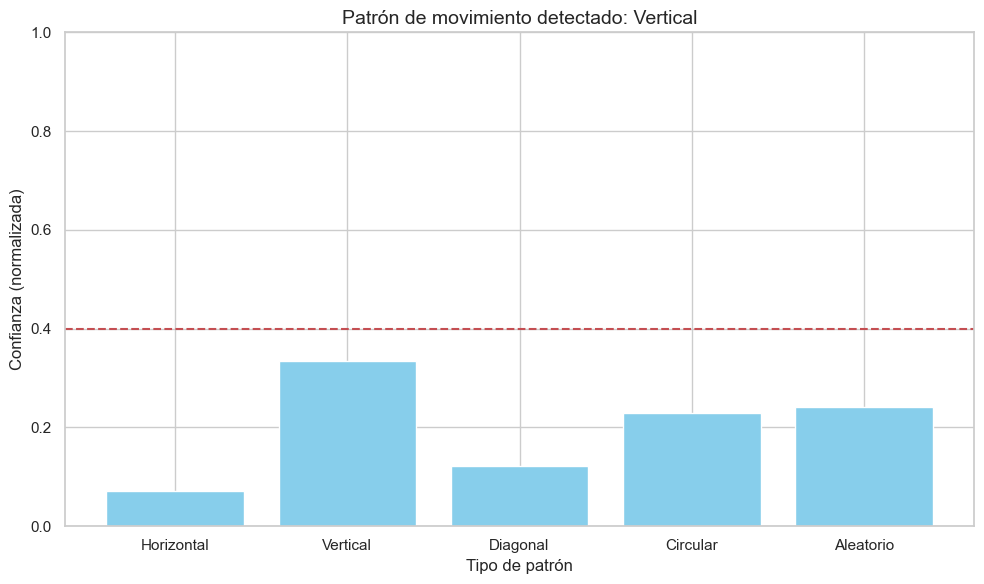

Análisis de patrón para paneoh.csv:
Patrón más probable: Vertical
Confianza por patrón:
  Vertical: 0.33
  Aleatorio: 0.24
  Circular: 0.23
  Diagonal: 0.12
  Horizontal: 0.07

Analizando paneod1.csv


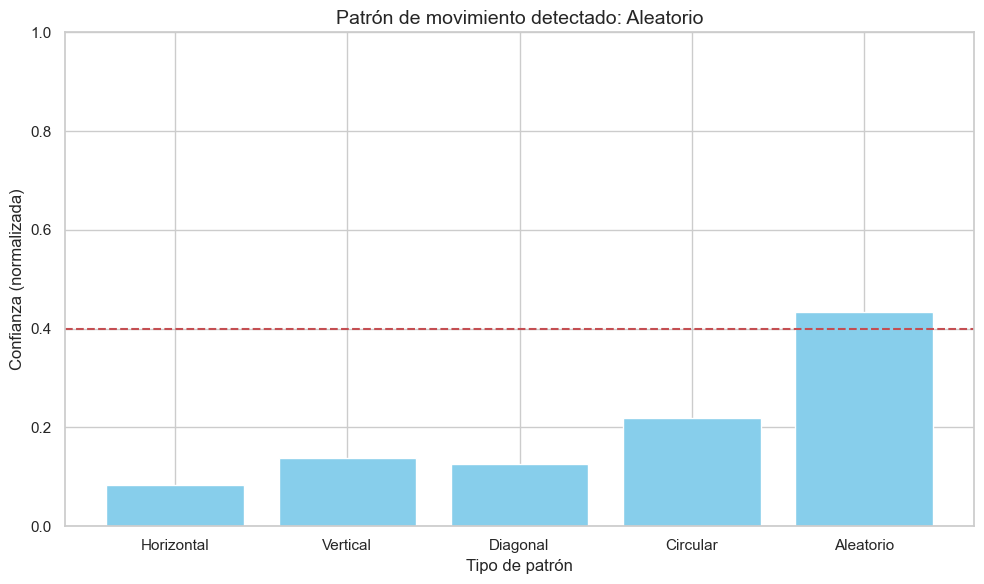

Análisis de patrón para paneod1.csv:
Patrón más probable: Aleatorio
Confianza por patrón:
  Aleatorio: 0.43
  Circular: 0.22
  Vertical: 0.14
  Diagonal: 0.13
  Horizontal: 0.08

Analizando aaaaaaaaaaaa.csv
Se adaptaron los nombres de columnas para aaaaaaaaaaaa.csv


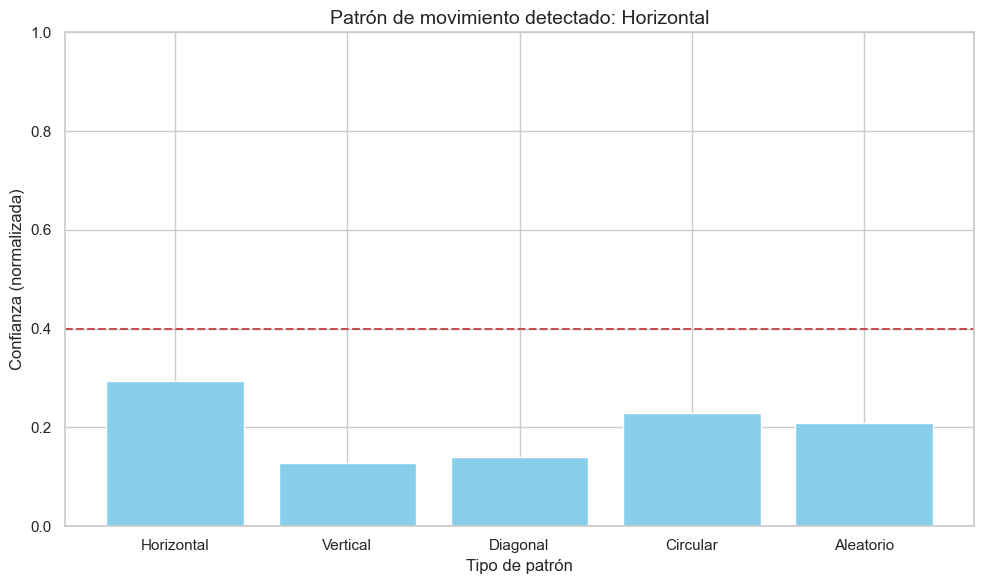

Análisis de patrón para aaaaaaaaaaaa.csv:
Patrón más probable: Horizontal
Confianza por patrón:
  Horizontal: 0.29
  Circular: 0.23
  Aleatorio: 0.21
  Diagonal: 0.14
  Vertical: 0.13

Analizando locura.csv


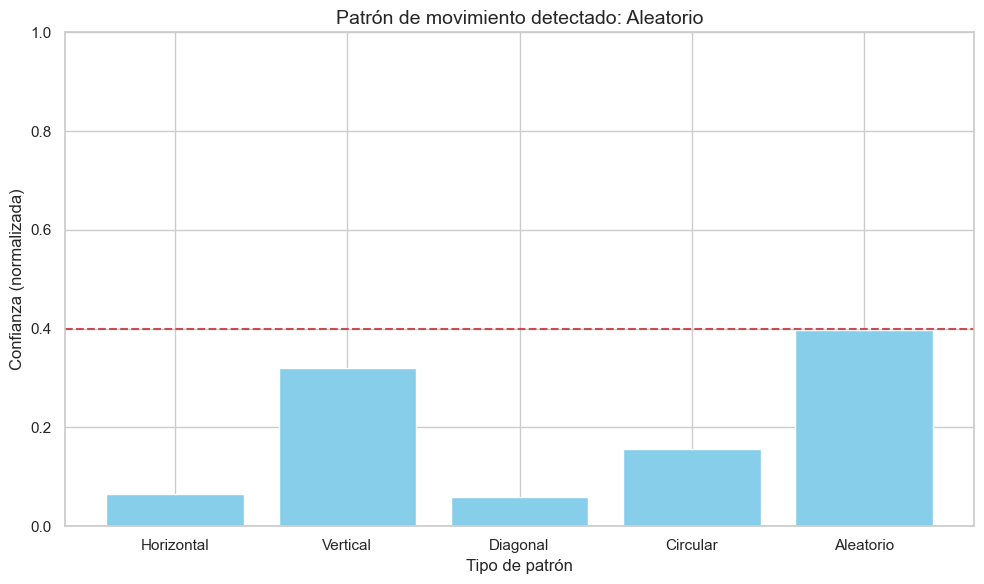

Análisis de patrón para locura.csv:
Patrón más probable: Aleatorio
Confianza por patrón:
  Aleatorio: 0.40
  Vertical: 0.32
  Circular: 0.16
  Horizontal: 0.07
  Diagonal: 0.06

Analizando locura2.csv


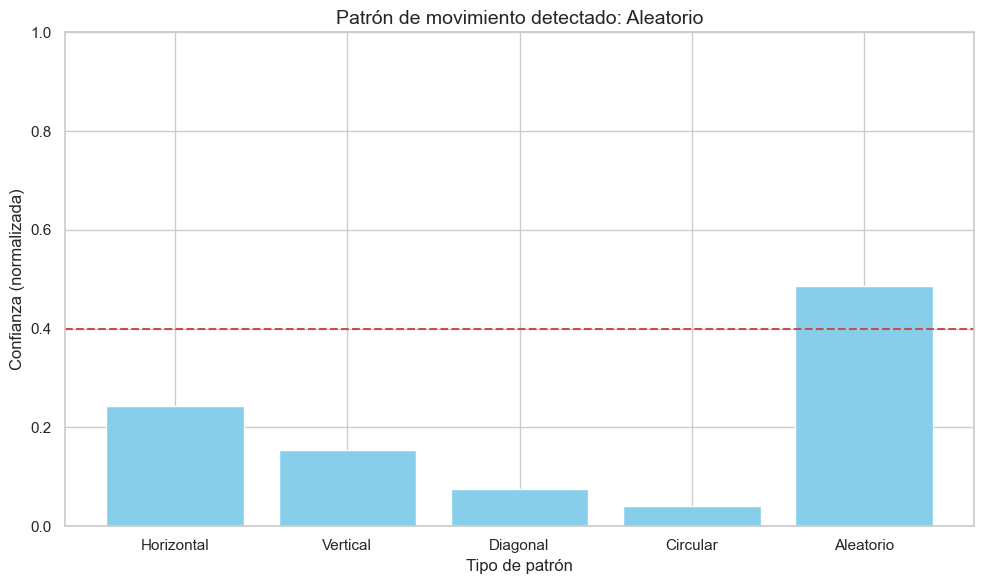

Análisis de patrón para locura2.csv:
Patrón más probable: Aleatorio
Confianza por patrón:
  Aleatorio: 0.49
  Horizontal: 0.24
  Vertical: 0.15
  Diagonal: 0.07
  Circular: 0.04

Analizando paneov.csv


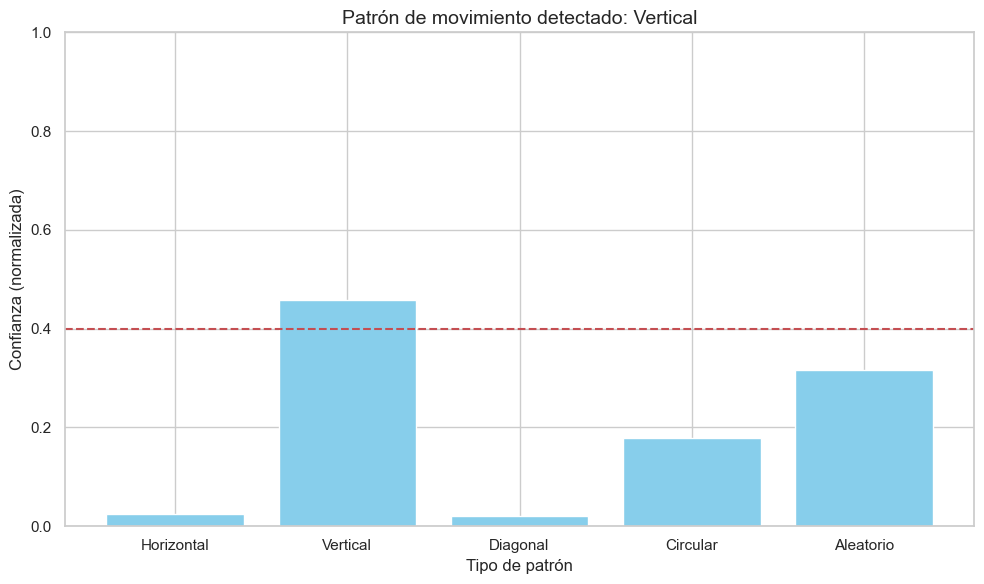

Análisis de patrón para paneov.csv:
Patrón más probable: Vertical
Confianza por patrón:
  Vertical: 0.46
  Aleatorio: 0.32
  Circular: 0.18
  Horizontal: 0.03
  Diagonal: 0.02

Analizando test1.csv
Se adaptaron los nombres de columnas para test1.csv


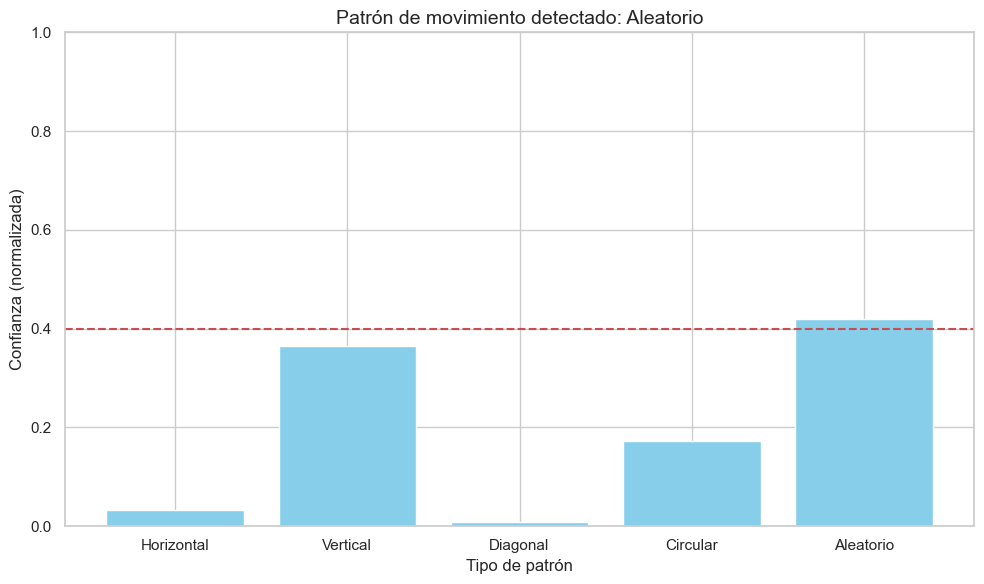

Análisis de patrón para test1.csv:
Patrón más probable: Aleatorio
Confianza por patrón:
  Aleatorio: 0.42
  Vertical: 0.37
  Circular: 0.17
  Horizontal: 0.03
  Diagonal: 0.01

Analizando resultados_analisis.csv
Advertencia: El archivo resultados_analisis.csv tiene una estructura diferente.
Columnas encontradas: ['Archivo', 'Patrón Detectado', 'Confianza']
Error al analizar resultados_analisis.csv: unsupported operand type(s) for -: 'str' and 'str'

Comparación de patrones detectados:
            Archivo Patrón Detectado  Confianza
0        paneoh.csv         Vertical   0.334137
1       paneod1.csv        Aleatorio   0.433581
2  aaaaaaaaaaaa.csv       Horizontal   0.294947
3        locura.csv        Aleatorio   0.397327
4       locura2.csv        Aleatorio   0.486357
5        paneov.csv         Vertical   0.457817
6         test1.csv        Aleatorio   0.419585


<Figure size 1000x600 with 0 Axes>

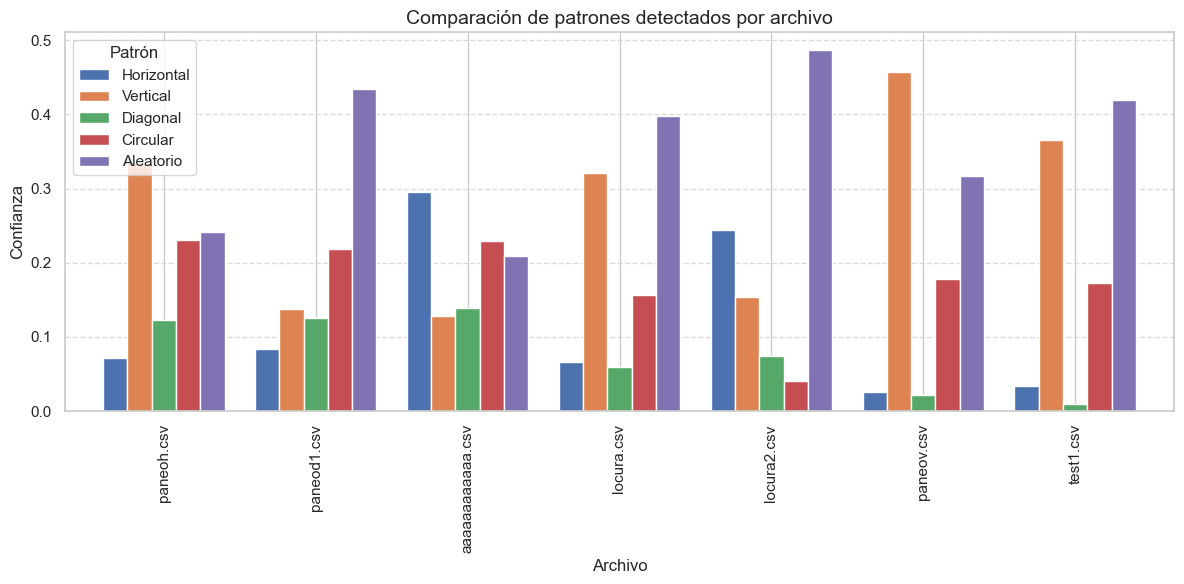


Resultados exportados a: resultados_analisis.csv


In [11]:
def analizar_todos_archivos():
    """
    Analiza todos los archivos CSV disponibles y compara resultados
    """
    archivos_csv = listar_csv()
    
    if not archivos_csv:
        print("No se encontraron archivos CSV para analizar")
        return
    
    # Recolectar resultados de todos los archivos
    resultados = {}
    
    for archivo in archivos_csv:
        print(f"\n{'='*50}")
        print(f"Analizando {archivo}")
        print(f"{'='*50}")
        
        try:
            # Detectar patrón de movimiento
            patron, confianza = detectar_patron_movimiento(archivo)
            
            # Guardar resultados
            resultados[archivo] = {
                'patron': patron,
                'confianza': confianza
            }
        except Exception as e:
            print(f"Error al analizar {archivo}: {str(e)}")
    
    # Mostrar tabla comparativa
    patrones = []
    for archivo, res in resultados.items():
        nombre_archivo = os.path.basename(archivo)
        patron = res['patron']
        confianza = res['confianza'][patron]
        patrones.append({
            'Archivo': nombre_archivo,
            'Patrón Detectado': patron,
            'Confianza': confianza
        })
    
    df_resultados = pd.DataFrame(patrones)
    print("\nComparación de patrones detectados:")
    print(df_resultados)
    
    # Visualizar comparación
    plt.figure(figsize=(10, 6))
    
    # Gráfico de barras agrupadas para comparar confianzas por patrón
    data = []
    patrones_unicos = ['Horizontal', 'Vertical', 'Diagonal', 'Circular', 'Aleatorio']
    
    for archivo, res in resultados.items():
        nombre_archivo = os.path.basename(archivo)
        data.append({
            'Archivo': nombre_archivo,
            **{patron: res['confianza'].get(patron, 0) for patron in patrones_unicos}
        })
    
    df_confianzas = pd.DataFrame(data)
    df_confianzas.set_index('Archivo', inplace=True)
    
    ax = df_confianzas.plot(kind='bar', figsize=(12, 6), width=0.8)
    ax.set_title('Comparación de patrones detectados por archivo', fontsize=14)
    ax.set_xlabel('Archivo')
    ax.set_ylabel('Confianza')
    ax.legend(title='Patrón')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Exportar resultados a CSV
    df_resultados.to_csv('resultados_analisis.csv', index=False)
    print(f"\nResultados exportados a: resultados_analisis.csv")
    
    return df_resultados

# Ejecutar análisis de todos los archivos
if archivos_csv:
    df_resultados = analizar_todos_archivos()

## Conclusiones

El análisis de los datos de los fototransistores nos permite extraer patrones de movimiento de la fuente luminosa basándonos en la correlación entre los sensores y sus tasas de cambio. Los resultados muestran:

1. **Patrones de movimiento**: Podemos detectar movimientos horizontales, verticales, diagonales, circulares o aleatorios basándonos en las correlaciones entre los sensores y en características espaciotemporales como la rectitud, varianza en X e Y, y circularidad de la trayectoria.

2. **Visualización espaciotemporal**: Las visualizaciones animadas y estáticas nos permiten observar cómo evoluciona la posición de la fuente luminosa a lo largo del tiempo, ayudándonos a entender mejor los patrones de movimiento.

3. **Mapas de calor**: La representación espacial de la intensidad luminosa mediante mapas de calor permite visualizar claramente la distribución de luz en cada experimento, facilitando la identificación de patrones y la comparación entre diferentes movimientos.

4. **Análisis de eventos**: Podemos detectar cuándo ocurren cambios significativos en la intensidad de luz y caracterizar estos eventos en función de su duración e intensidad.

5. **Extracción de características**: Hemos extraído métricas cuantitativas que permiten clasificar automáticamente los patrones de movimiento, como la relación entre varianzas, la concentración direccional y la circularidad de la trayectoria.

6. **Comparación entre experimentos**: El análisis comparativo nos permite identificar claramente las diferencias entre los distintos patrones de movimiento y ver cómo cada uno genera una huella característica en los datos de los sensores.

Este análisis demuestra cómo un arreglo simple de fototransistores puede utilizarse para seguir el movimiento de una fuente de luz con notable precisión, lo que podría aplicarse en sistemas de seguimiento de posición, interfaces de usuario basadas en luz, o sistemas de detección de movimiento de bajo costo.

Las técnicas de filtrado y procesamiento de señales aplicadas mejoran significativamente la calidad de los datos, permitiendo una detección más precisa de los patrones incluso en presencia de ruido o variaciones en la intensidad luminosa.

## 11. Visualización Espacio-Temporal Avanzada

Para comprender mejor cómo evoluciona la luz a través del espacio y el tiempo, implementamos visualizaciones más avanzadas que muestren la trayectoria de la fuente luminosa y cómo cambia la intensidad en cada sensor a lo largo del tiempo.

Visualizando evolución espacio-temporal para: paneoh.csv


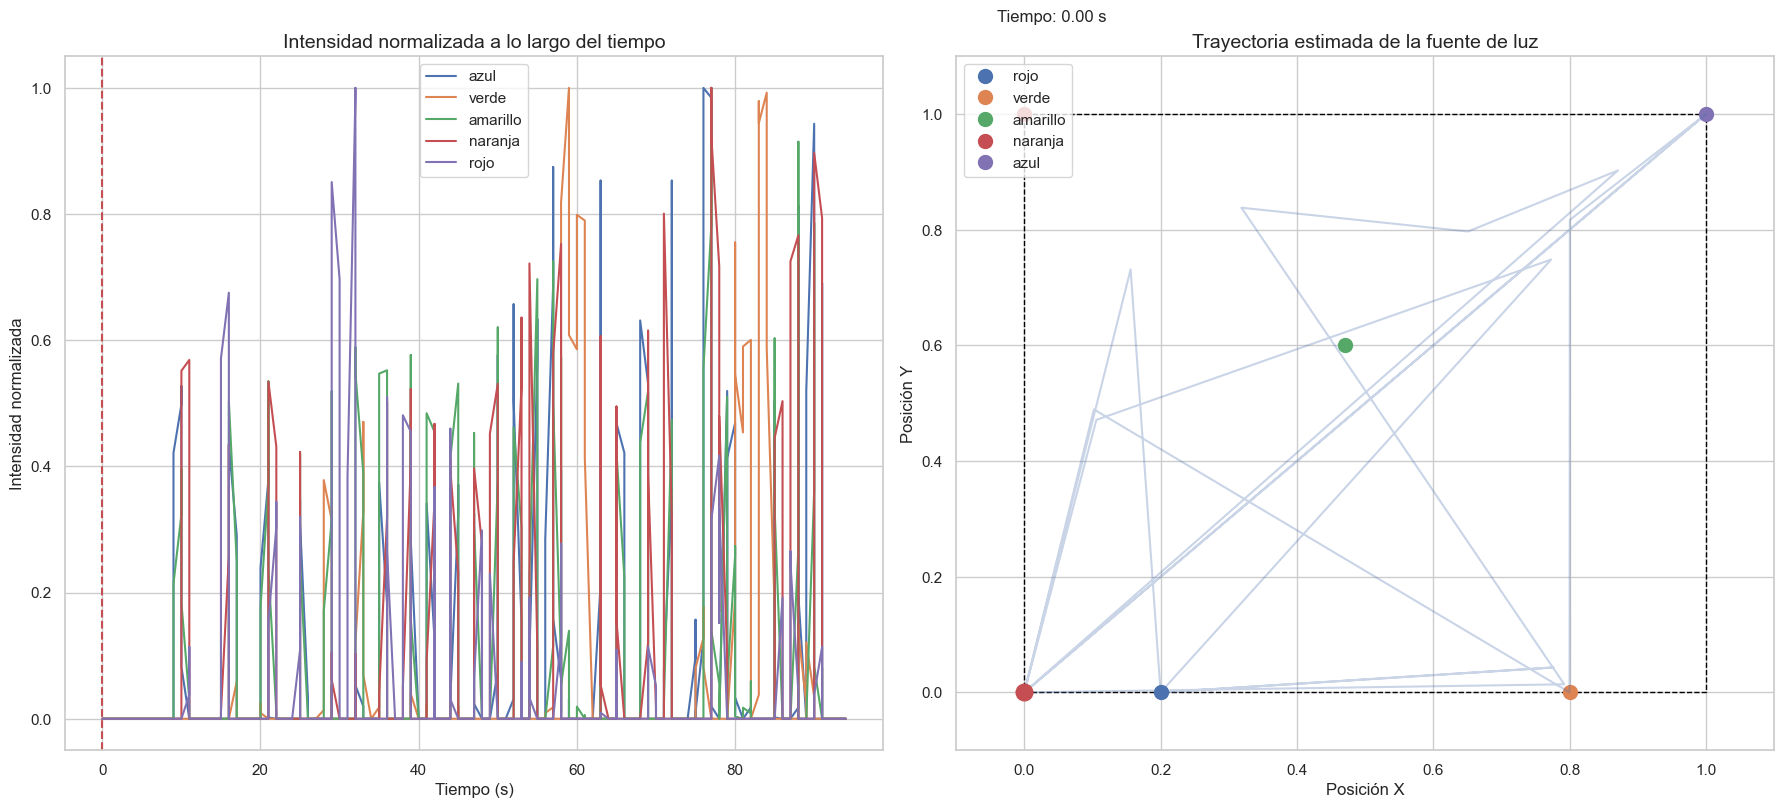

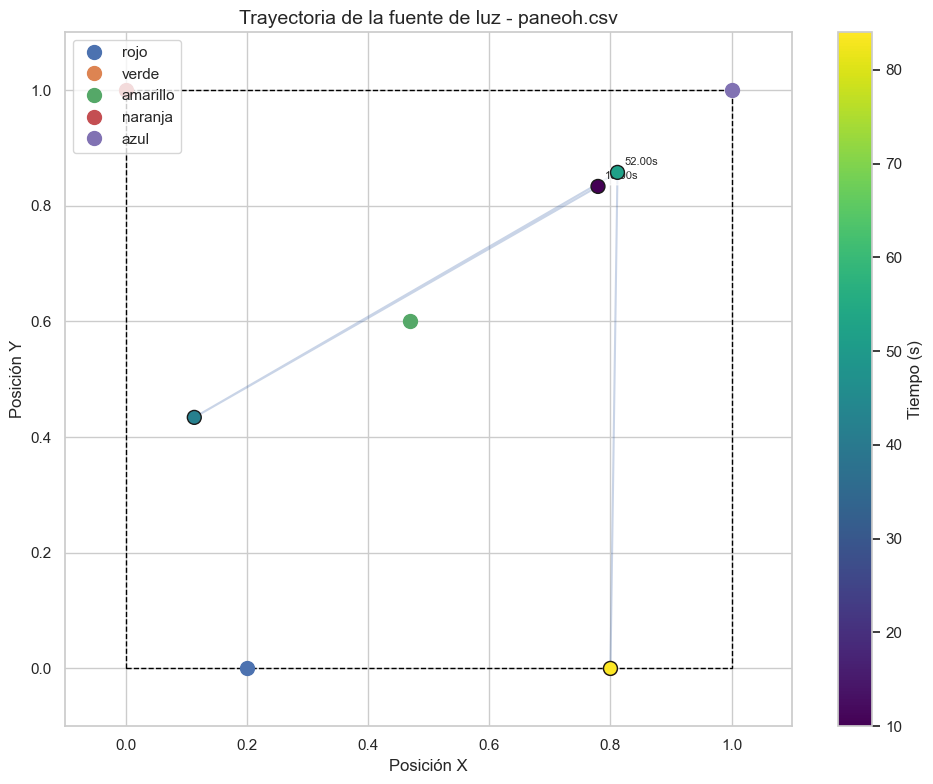

In [12]:
def visualizar_evolucion_espaciotemporal(archivo, frames=50):
    """
    Crea una visualización avanzada de la evolución espaciotemporal de la luz
    detectada por los fototransistores, mostrando la trayectoria estimada.
    
    Args:
        archivo: Ruta al archivo CSV con los datos
        frames: Número de frames a mostrar (si es None, usa todos los datos)
    """
    # Cargar y procesar datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Usar las posiciones de sensores definidas globalmente
    posiciones = POSICIONES_SENSORES
    sensores_orden = ORDEN_SENSORES
    
    # Seleccionar frames equidistantes para la visualización
    if frames is not None and frames < len(df):
        indices = np.linspace(0, len(df) - 1, frames, dtype=int)
        df_vis = df.iloc[indices].copy()
    else:
        df_vis = df.copy()
    
    # Crear figura para la visualización
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # 1. Gráfico de la intensidad en cada sensor a lo largo del tiempo
    ax1 = axes[0]
    for sensor in sensores_orden:
        ax1.plot(df['tiempo'], df[f'{sensor}_norm'], label=sensor)
    
    # Añadir línea vertical para el tiempo actual (se actualizará)
    tiempo_line = ax1.axvline(x=df_vis['tiempo'].iloc[0], color='r', linestyle='--')
    
    ax1.set_title('Intensidad normalizada a lo largo del tiempo', fontsize=14)
    ax1.set_xlabel('Tiempo (s)')
    ax1.set_ylabel('Intensidad normalizada')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Gráfico espacial con la posición estimada de la fuente de luz
    ax2 = axes[1]
    
    # Dibujar los límites de la protoboard
    rect = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linestyle='--')
    ax2.add_patch(rect)
    
    # Dibujar los sensores
    for sensor, (x, y) in posiciones.items():
        ax2.plot(x, y, 'o', markersize=10, label=sensor)
    
    # Estimar el centro de masa (posición de la luz) para cada frame
    df_vis['pos_x'] = 0
    df_vis['pos_y'] = 0
    
    for idx, row in df_vis.iterrows():
        # Calcular posición ponderada por intensidad normalizada
        suma_pesos = 0
        pos_x = 0
        pos_y = 0
        
        for sensor in sensores_orden:
            x, y = posiciones[sensor]
            peso = row[f'{sensor}_norm']
            pos_x += x * peso
            pos_y += y * peso
            suma_pesos += peso
        
        if suma_pesos > 0:
            df_vis.at[idx, 'pos_x'] = pos_x / suma_pesos
            df_vis.at[idx, 'pos_y'] = pos_y / suma_pesos
    
    # Dibujar la trayectoria completa
    ax2.plot(df_vis['pos_x'], df_vis['pos_y'], 'b-', alpha=0.3)
    
    # Marcador para la posición actual (se actualizará)
    punto_actual, = ax2.plot([], [], 'ro', markersize=12)
    
    # Establecer límites y etiquetas
    ax2.set_xlim(-0.1, 1.1)
    ax2.set_ylim(-0.1, 1.1)
    ax2.set_title('Trayectoria estimada de la fuente de luz', fontsize=14)
    ax2.set_xlabel('Posición X')
    ax2.set_ylabel('Posición Y')
    ax2.legend(loc='upper left')
    ax2.grid(True)
    
    # Añadir información del tiempo actual
    time_text = ax2.text(0.05, 1.05, '', transform=ax2.transAxes)
    
    plt.tight_layout()
    
    # Función para actualizar la visualización en cada frame
    def update(frame):
        tiempo_actual = df_vis['tiempo'].iloc[frame]
        pos_x = df_vis['pos_x'].iloc[frame]
        pos_y = df_vis['pos_y'].iloc[frame]
        
        # Actualizar la línea de tiempo
        tiempo_line.set_xdata([tiempo_actual, tiempo_actual])
        
        # Actualizar la posición actual
        punto_actual.set_data([pos_x], [pos_y])
        
        # Actualizar el texto del tiempo
        time_text.set_text(f'Tiempo: {tiempo_actual:.2f} s')
        
        return tiempo_line, punto_actual, time_text
    
    # Crear la animación
    ani = FuncAnimation(fig, update, frames=len(df_vis), 
                        interval=100, blit=True)
    
    # Mostrar la figura
    plt.show()
    
    # Generar una versión estática con múltiples puntos de tiempo
    visualizar_trayectoria_estatica(archivo)
    
    return ani

def visualizar_trayectoria_estatica(archivo, num_frames=10):
    """
    Crea una visualización estática de la trayectoria de la fuente de luz
    con puntos a lo largo del tiempo codificados por color.
    """
    # Cargar y procesar datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Usar las posiciones de sensores definidas globalmente
    posiciones = POSICIONES_SENSORES
    sensores_orden = ORDEN_SENSORES
    
    # Seleccionar frames equidistantes para la visualización
    indices = np.linspace(0, len(df) - 1, num_frames, dtype=int)
    df_vis = df.iloc[indices].copy()
    
    # Estimar el centro de masa (posición de la luz) para cada frame
    pos_x = []
    pos_y = []
    tiempos = []
    
    for idx, row in df_vis.iterrows():
        # Calcular posición ponderada por intensidad normalizada
        suma_pesos = 0
        x_pos = 0
        y_pos = 0
        
        for sensor in sensores_orden:
            x, y = posiciones[sensor]
            peso = row[f'{sensor}_norm']
            x_pos += x * peso
            y_pos += y * peso
            suma_pesos += peso
        
        if suma_pesos > 0:
            pos_x.append(x_pos / suma_pesos)
            pos_y.append(y_pos / suma_pesos)
            tiempos.append(row['tiempo'])
    
    # Crear figura
    plt.figure(figsize=(10, 8))
    
    # Dibujar los límites de la protoboard
    rect = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linestyle='--')
    plt.gca().add_patch(rect)
    
    # Dibujar los sensores
    for sensor, (x, y) in posiciones.items():
        plt.plot(x, y, 'o', markersize=10, label=sensor)
    
    # Dibujar la trayectoria completa
    plt.plot(pos_x, pos_y, 'b-', alpha=0.3)
    
    # Dibujar puntos a lo largo de la trayectoria con un mapa de colores según el tiempo
    scatter = plt.scatter(pos_x, pos_y, c=tiempos, cmap='viridis', 
                s=100, edgecolor='k', zorder=10)
    
    # Añadir etiquetas con el tiempo en algunos puntos
    for i, (x, y, t) in enumerate(zip(pos_x, pos_y, tiempos)):
        if i % max(1, num_frames // 5) == 0:  # Etiquetar solo algunos puntos
            plt.annotate(f'{t:.2f}s', (x, y), xytext=(5, 5), 
                        textcoords='offset points', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))
    
    # Añadir barra de colores para el tiempo
    cbar = plt.colorbar(scatter)
    cbar.set_label('Tiempo (s)')
    
    # Establecer límites y etiquetas
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.title(f'Trayectoria de la fuente de luz - {os.path.basename(archivo)}', fontsize=14)
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')
    plt.legend(loc='upper left')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return

# Demostrar la visualización espacio-temporal con un archivo de ejemplo
if archivos_csv:
    print("Visualizando evolución espacio-temporal para:", archivos_csv[0])
    ani = visualizar_evolucion_espaciotemporal(archivos_csv[0], frames=30)

Comparando patrones entre archivos...
Analizando características de paneoh.csv...
Analizando características de paneod1.csv...
Analizando características de aaaaaaaaaaaa.csv...
Se adaptaron los nombres de columnas para aaaaaaaaaaaa.csv
Analizando características de locura.csv...
Analizando características de locura2.csv...
Analizando características de paneov.csv...
Analizando características de locura.csv...
Analizando características de locura2.csv...
Analizando características de paneov.csv...
Analizando características de test1.csv...
Se adaptaron los nombres de columnas para test1.csv
Analizando características de resultados_analisis.csv...
Advertencia: El archivo resultados_analisis.csv tiene una estructura diferente.
Columnas encontradas: ['Archivo', 'Patrón Detectado', 'Confianza']
Error al analizar resultados_analisis.csv: unsupported operand type(s) for -: 'str' and 'str'

Características extraídas por archivo:
            Archivo         Patrón  Confianza  Distancia Total  R

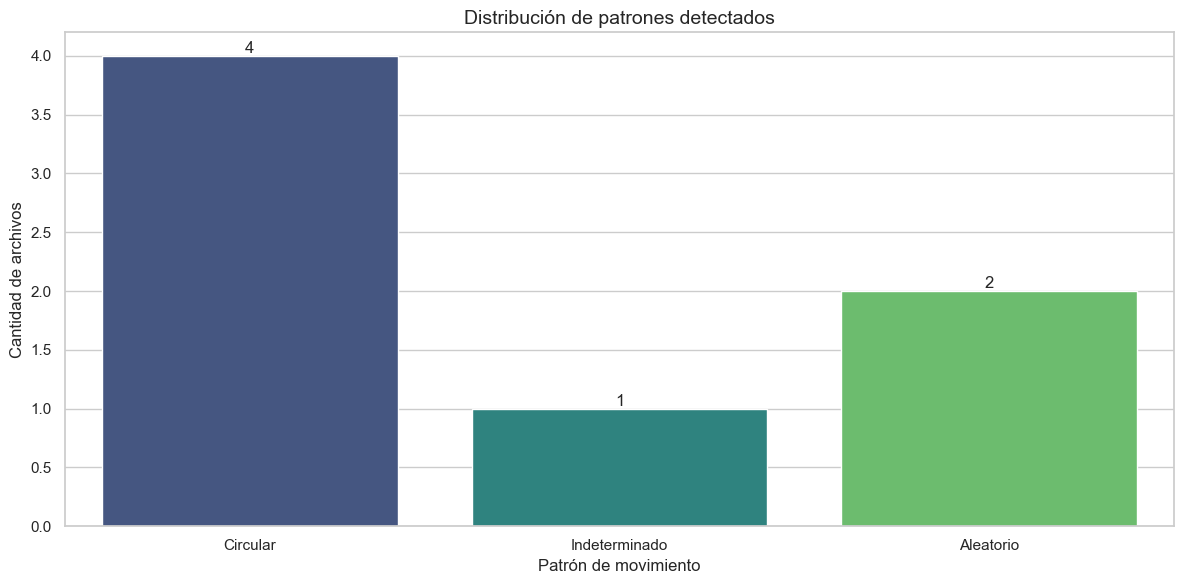

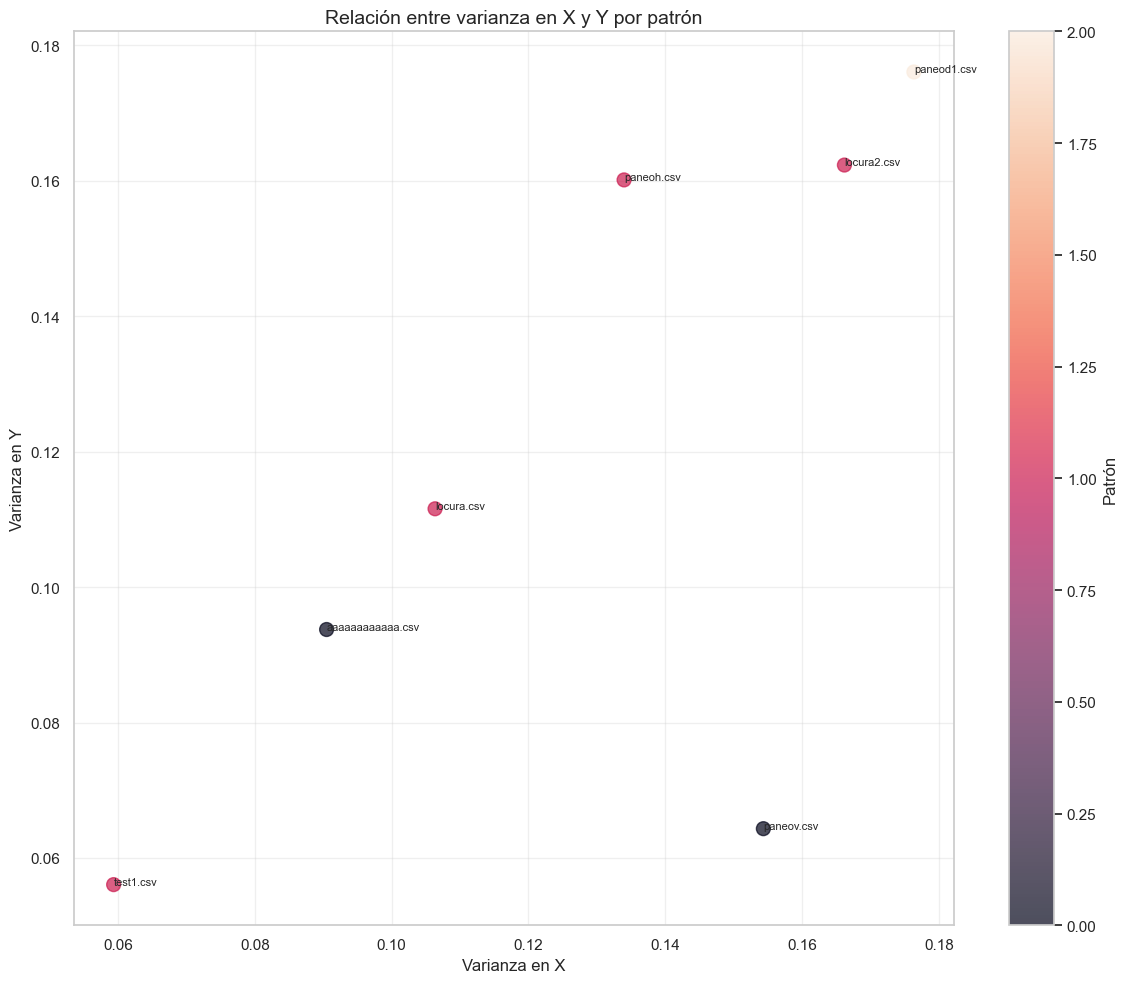

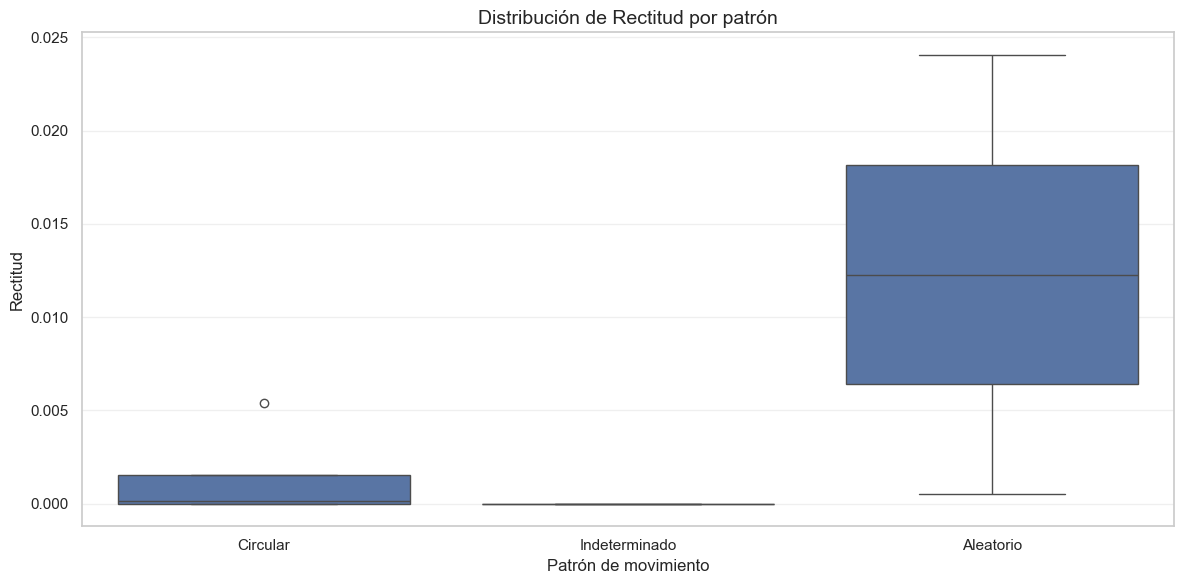

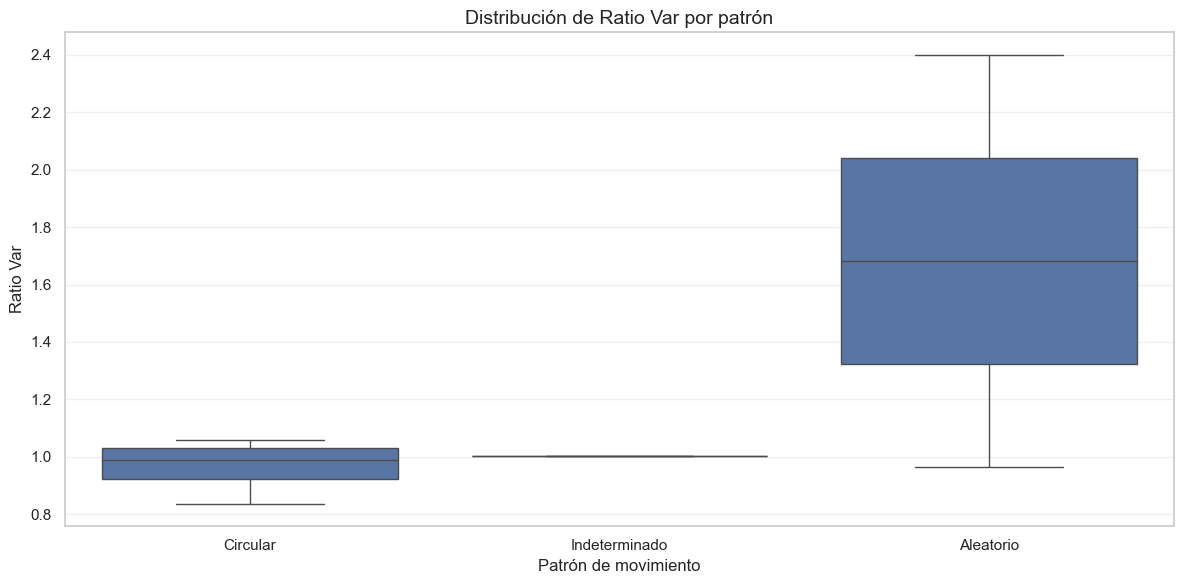

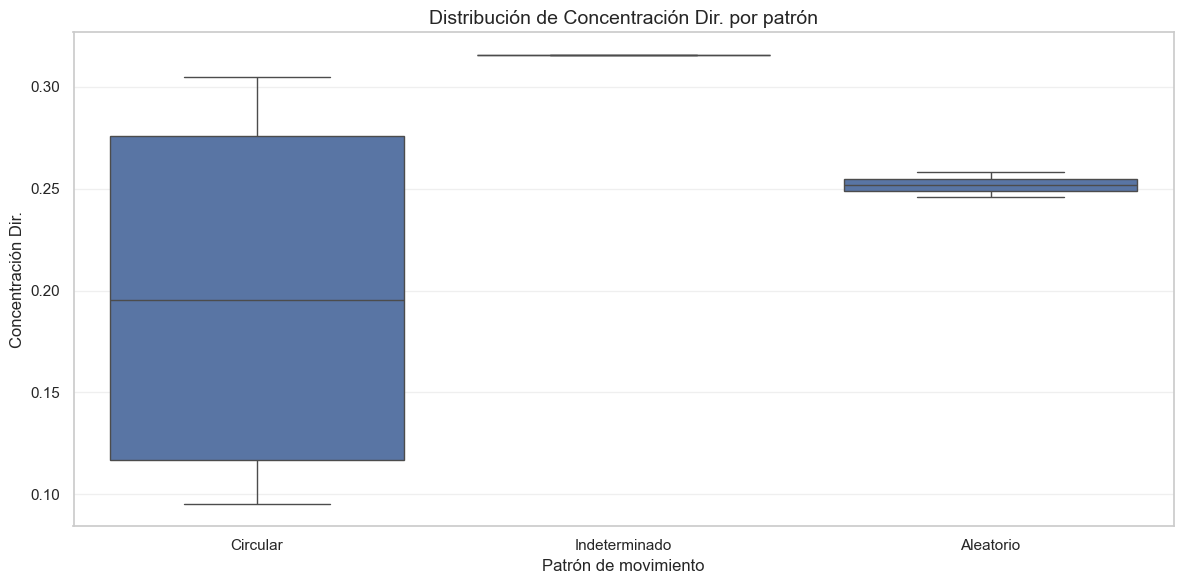

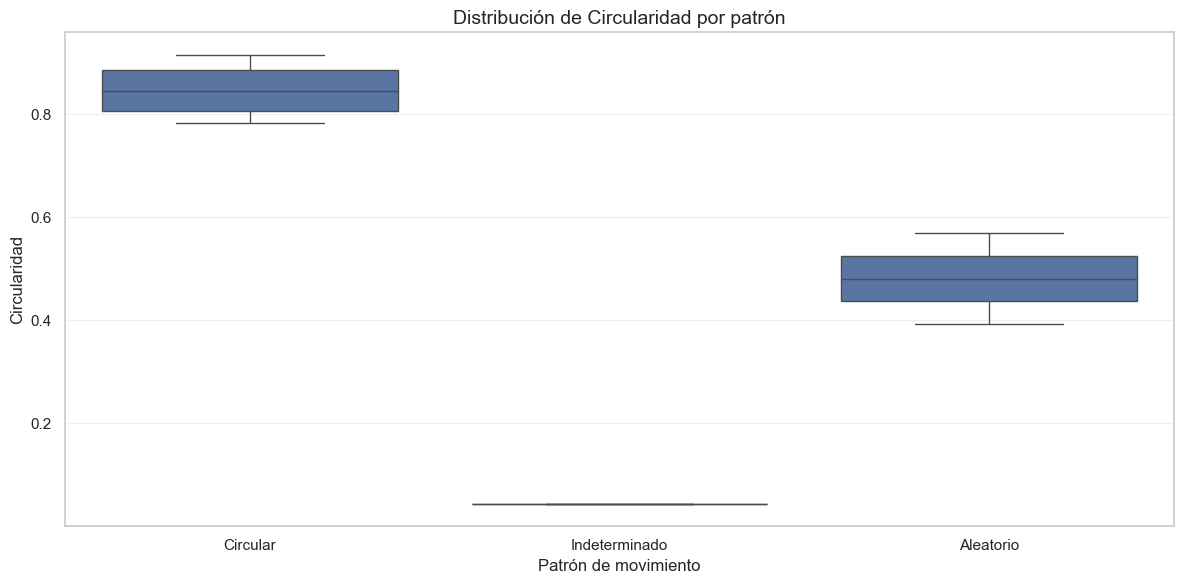

In [13]:
def extraer_caracteristicas_patron(archivo):
    """
    Extrae características avanzadas para identificar el patrón de movimiento
    """
    # Cargar y procesar datos
    procesador = ProcesadorFototransistores(archivo)
    df = procesador.obtener_dataframe_procesado()
    
    # Posiciones de los sensores
    posiciones = {
        'azul': (0, 0),      # Esquina superior izquierda
        'verde': (1, 0),     # Esquina superior derecha
        'amarillo': (0.5, 0.5),  # Centro
        'naranja': (0, 1),   # Esquina inferior izquierda
        'rojo': (1, 1)       # Esquina inferior derecha
    }
    
    # 1. Calcular trayectoria estimada
    trayectoria_x = []
    trayectoria_y = []
    
    for idx, row in df.iterrows():
        # Calcular posición ponderada por intensidad normalizada
        suma_pesos = 0
        pos_x = 0
        pos_y = 0
        
        for sensor, (x, y) in posiciones.items():
            peso = row[f'{sensor}_norm']
            pos_x += x * peso
            pos_y += y * peso
            suma_pesos += peso
        
        if suma_pesos > 0:
            trayectoria_x.append(pos_x / suma_pesos)
            trayectoria_y.append(pos_y / suma_pesos)
    
    # 2. Características de la trayectoria
    caracteristicas = {}
    
    # Convertir a array para cálculos
    trayectoria_x = np.array(trayectoria_x)
    trayectoria_y = np.array(trayectoria_y)
    
    # Calcular distancia total recorrida
    dx = np.diff(trayectoria_x)
    dy = np.diff(trayectoria_y)
    distancias = np.sqrt(dx**2 + dy**2)
    caracteristicas['distancia_total'] = np.sum(distancias)
    
    # Calcular rectitud de la trayectoria (distancia directa / distancia total)
    if len(trayectoria_x) > 1:
        dist_directa = np.sqrt((trayectoria_x[-1] - trayectoria_x[0])**2 + 
                              (trayectoria_y[-1] - trayectoria_y[0])**2)
        if caracteristicas['distancia_total'] > 0:
            caracteristicas['rectitud'] = dist_directa / caracteristicas['distancia_total']
        else:
            caracteristicas['rectitud'] = 1.0
    else:
        caracteristicas['rectitud'] = 1.0
    
    # Calcular varianza en X e Y
    caracteristicas['varianza_x'] = np.var(trayectoria_x)
    caracteristicas['varianza_y'] = np.var(trayectoria_y)
    caracteristicas['ratio_varianza'] = (caracteristicas['varianza_x'] / 
                                       (caracteristicas['varianza_y'] + 1e-10))
    
    # Calcular dirección predominante
    if len(dx) > 0 and len(dy) > 0:
        angulos = np.arctan2(dy, dx) * 180 / np.pi
        # Convertir a rango 0-180 (sin signo)
        angulos = np.abs(angulos)
        # Calcular histograma de ángulos
        hist, _ = np.histogram(angulos, bins=18, range=(0, 180))
        # Ángulo más frecuente
        angulo_predominante = (np.argmax(hist) * 10) + 5  # centro del bin
        caracteristicas['angulo_predominante'] = angulo_predominante
        
        # Concentración en la dirección predominante
        concentracion = hist.max() / (np.sum(hist) + 1e-10)
        caracteristicas['concentracion_direccional'] = concentracion
    else:
        caracteristicas['angulo_predominante'] = 0
        caracteristicas['concentracion_direccional'] = 1.0
    
    # Calcular circularidad (usando análisis de componentes principales)
    if len(trayectoria_x) > 2:
        # Centrar los datos
        traj_centered = np.column_stack([
            trayectoria_x - np.mean(trayectoria_x),
            trayectoria_y - np.mean(trayectoria_y)
        ])
        
        # Calcular matriz de covarianza
        cov_matrix = np.cov(traj_centered.T)
        
        # Calcular autovalores
        try:
            eigenvalues, _ = np.linalg.eig(cov_matrix)
            # Ordenar autovalores
            eigenvalues = np.sort(eigenvalues)
            
            # Calcular circularidad (ratio entre autovalores)
            if eigenvalues[-1] > 0:
                caracteristicas['circularidad'] = eigenvalues[0] / eigenvalues[-1]
            else:
                caracteristicas['circularidad'] = 0
        except:
            caracteristicas['circularidad'] = 0
    else:
        caracteristicas['circularidad'] = 0
    
    # Determinar tipo de patrón basado en características
    # Horizontal: alta varianza en X, baja en Y, ángulo predominante cercano a 0 o 180
    # Vertical: baja varianza en X, alta en Y, ángulo predominante cercano a 90
    # Diagonal: varianzas similares, ángulo predominante cercano a 45 o 135
    # Circular: alta circularidad, baja rectitud
    # Aleatorio: baja concentración direccional
    
    patron_estimado = "Indeterminado"
    confianza = 0.0
    
    # Criterios para patrones
    if caracteristicas['circularidad'] > 0.7 and caracteristicas['rectitud'] < 0.3:
        patron_estimado = "Circular"
        confianza = min(1.0, caracteristicas['circularidad'] * (1 - caracteristicas['rectitud']))
    elif (caracteristicas['ratio_varianza'] > 3.0 and 
          (caracteristicas['angulo_predominante'] < 20 or caracteristicas['angulo_predominante'] > 160)):
        patron_estimado = "Horizontal"
        confianza = min(1.0, caracteristicas['ratio_varianza'] / 5.0)
    elif (caracteristicas['ratio_varianza'] < 0.33 and 
          (caracteristicas['angulo_predominante'] > 70 and caracteristicas['angulo_predominante'] < 110)):
        patron_estimado = "Vertical"
        confianza = min(1.0, 1.0 / (caracteristicas['ratio_varianza'] * 3.0))
    elif (caracteristicas['ratio_varianza'] > 0.7 and caracteristicas['ratio_varianza'] < 1.5 and
          ((caracteristicas['angulo_predominante'] > 30 and caracteristicas['angulo_predominante'] < 60) or 
           (caracteristicas['angulo_predominante'] > 120 and caracteristicas['angulo_predominante'] < 150))):
        patron_estimado = "Diagonal"
        confianza = min(1.0, caracteristicas['concentracion_direccional'])
    elif caracteristicas['concentracion_direccional'] < 0.3:
        patron_estimado = "Aleatorio"
        confianza = min(1.0, 1.0 - caracteristicas['concentracion_direccional'])
    
    caracteristicas['patron_estimado'] = patron_estimado
    caracteristicas['confianza'] = confianza
    
    return caracteristicas

def comparar_patrones_archivos():
    """
    Compara las características de los patrones de movimiento entre archivos
    """
    archivos_csv = listar_csv()
    
    if not archivos_csv:
        print("No se encontraron archivos CSV para analizar")
        return
    
    # Recolectar características de todos los archivos
    resultados = {}
    
    for archivo in archivos_csv:
        print(f"Analizando características de {archivo}...")
        try:
            caract = extraer_caracteristicas_patron(archivo)
            resultados[archivo] = caract
        except Exception as e:
            print(f"Error al analizar {archivo}: {str(e)}")
    
    # Crear DataFrame con resultados
    datos = []
    for archivo, caract in resultados.items():
        datos.append({
            'Archivo': os.path.basename(archivo),
            'Patrón': caract['patron_estimado'],
            'Confianza': caract['confianza'],
            'Distancia Total': caract['distancia_total'],
            'Rectitud': caract['rectitud'],
            'Var(X)': caract['varianza_x'],
            'Var(Y)': caract['varianza_y'],
            'Ratio Var': caract['ratio_varianza'],
            'Ángulo Predom.': caract['angulo_predominante'],
            'Concentración Dir.': caract['concentracion_direccional'],
            'Circularidad': caract['circularidad']
        })
    
    df_caracteristicas = pd.DataFrame(datos)
    
    # Mostrar tabla de características
    print("\nCaracterísticas extraídas por archivo:")
    print(df_caracteristicas)
    
    # Visualizaciones comparativas
    
    # 1. Gráfico de barras para patrones detectados
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(x='Patrón', data=df_caracteristicas, palette='viridis')
    plt.title('Distribución de patrones detectados', fontsize=14)
    plt.xlabel('Patrón de movimiento')
    plt.ylabel('Cantidad de archivos')
    
    # Añadir etiquetas con la cantidad
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Gráfico de dispersión para ver relaciones entre características
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(df_caracteristicas['Var(X)'], 
                         df_caracteristicas['Var(Y)'],
                         c=df_caracteristicas['Patrón'].astype('category').cat.codes,
                         s=100, alpha=0.7)
    
    # Añadir etiquetas
    for i, txt in enumerate(df_caracteristicas['Archivo']):
        plt.annotate(txt, 
                    (df_caracteristicas['Var(X)'].iloc[i], df_caracteristicas['Var(Y)'].iloc[i]),
                    fontsize=8)
    
    plt.colorbar(scatter, label='Patrón')
    plt.title('Relación entre varianza en X y Y por patrón', fontsize=14)
    plt.xlabel('Varianza en X')
    plt.ylabel('Varianza en Y')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. Gráfico de características por patrón
    caracteristicas_plot = ['Rectitud', 'Ratio Var', 'Concentración Dir.', 'Circularidad']
    
    for caract in caracteristicas_plot:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='Patrón', y=caract, data=df_caracteristicas)
        plt.title(f'Distribución de {caract} por patrón', fontsize=14)
        plt.xlabel('Patrón de movimiento')
        plt.ylabel(caract)
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    return df_caracteristicas

# Ejecutar el análisis comparativo
if len(archivos_csv) > 1:  # Solo si hay más de un archivo
    print("Comparando patrones entre archivos...")
    df_caracteristicas = comparar_patrones_archivos()
else:
    print("Se necesitan al menos dos archivos CSV para comparar patrones.")

## 13. Mapas de Calor por Archivo

A continuación, generamos mapas de calor para cada archivo CSV, mostrando la distribución de intensidades en los diferentes sensores a lo largo del tiempo. Esto nos permite visualizar patrones específicos y comparar los diferentes experimentos en términos de su distribución espacial de luz.

Generando mapa de calor para paneoh.csv como ejemplo...
Generando mapas de calor para paneoh.csv...


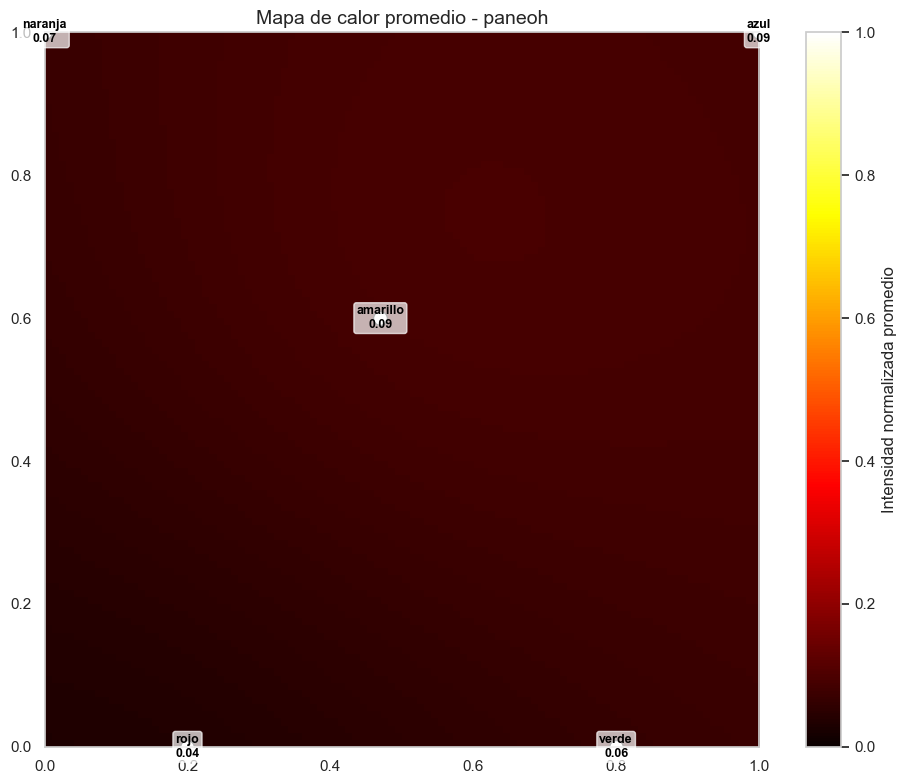

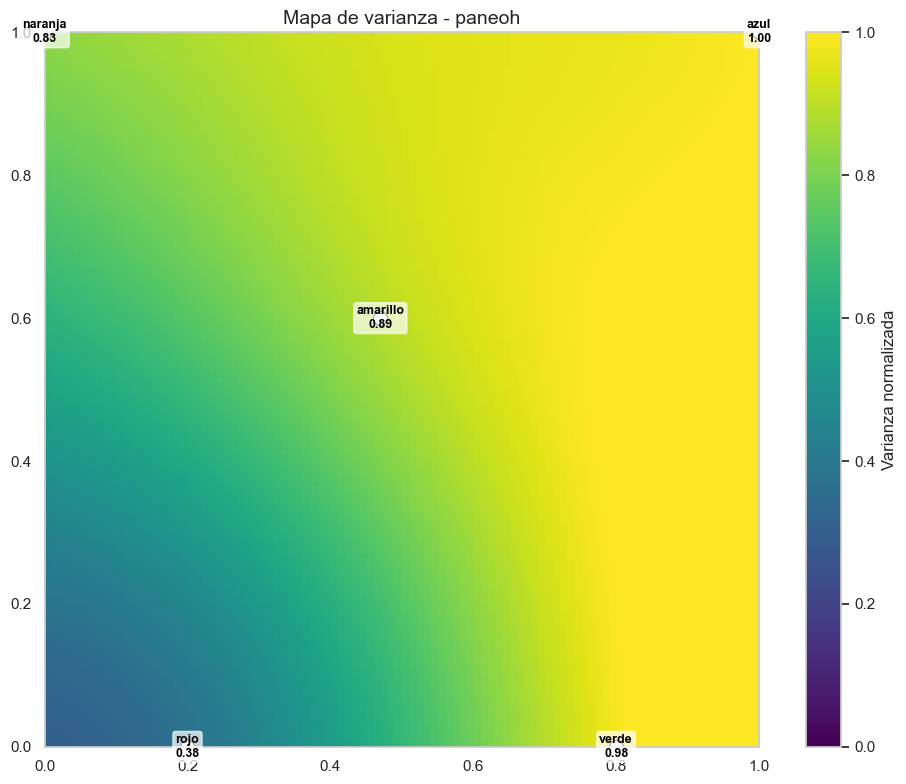

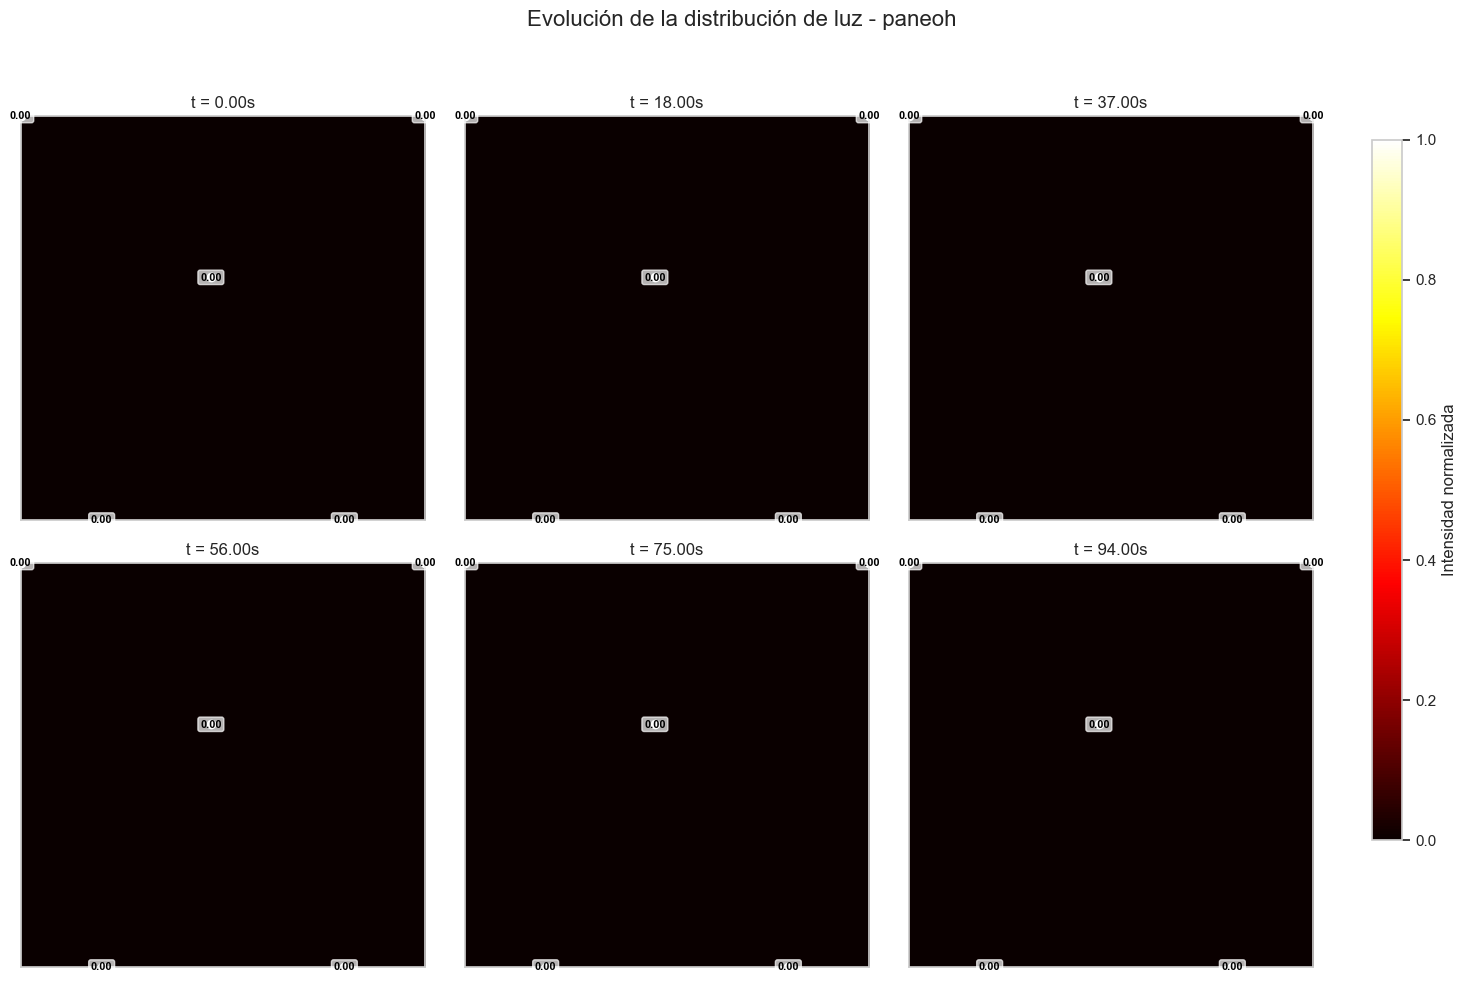

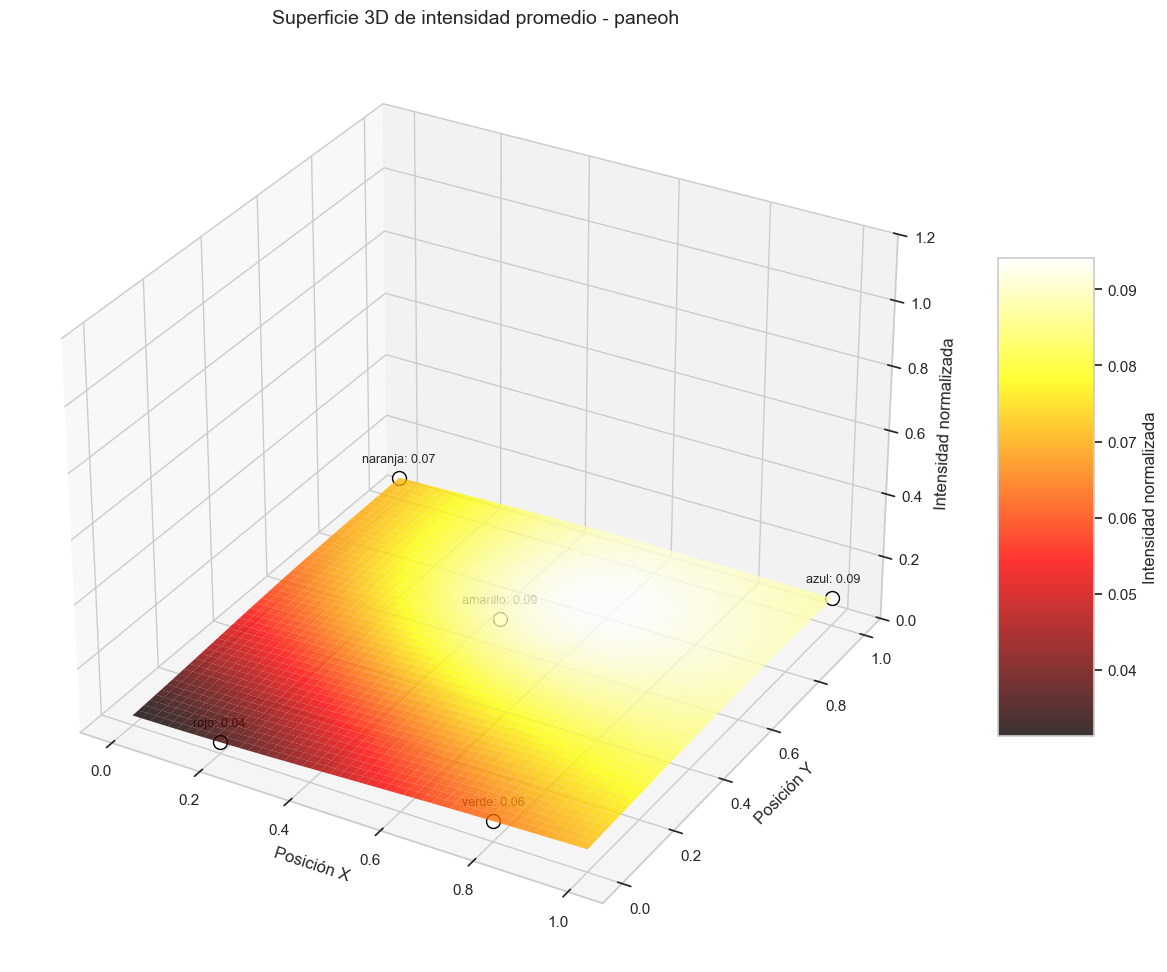

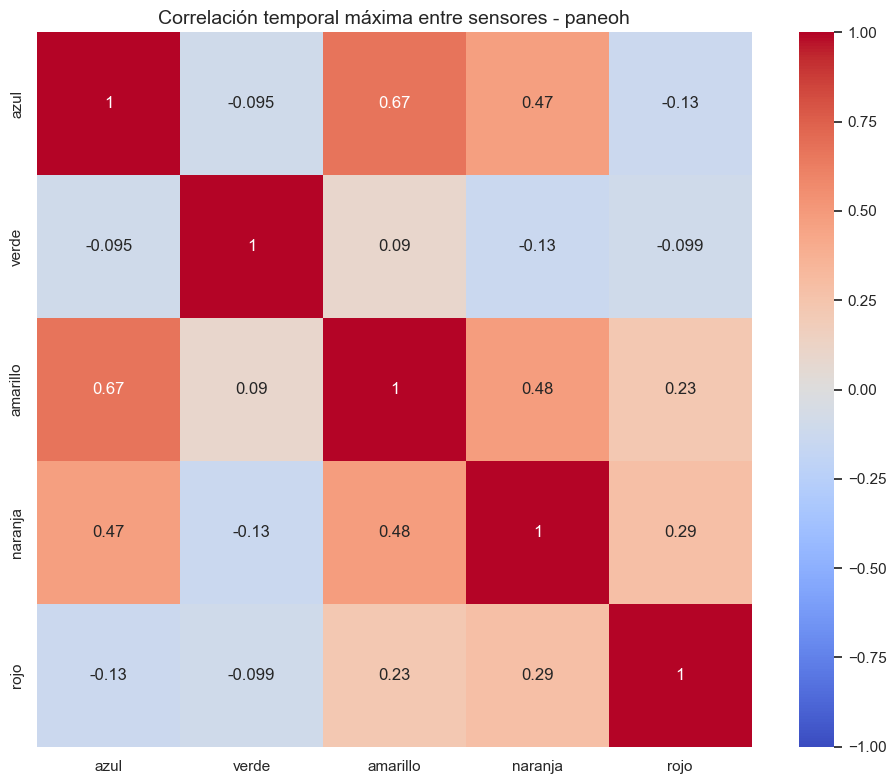

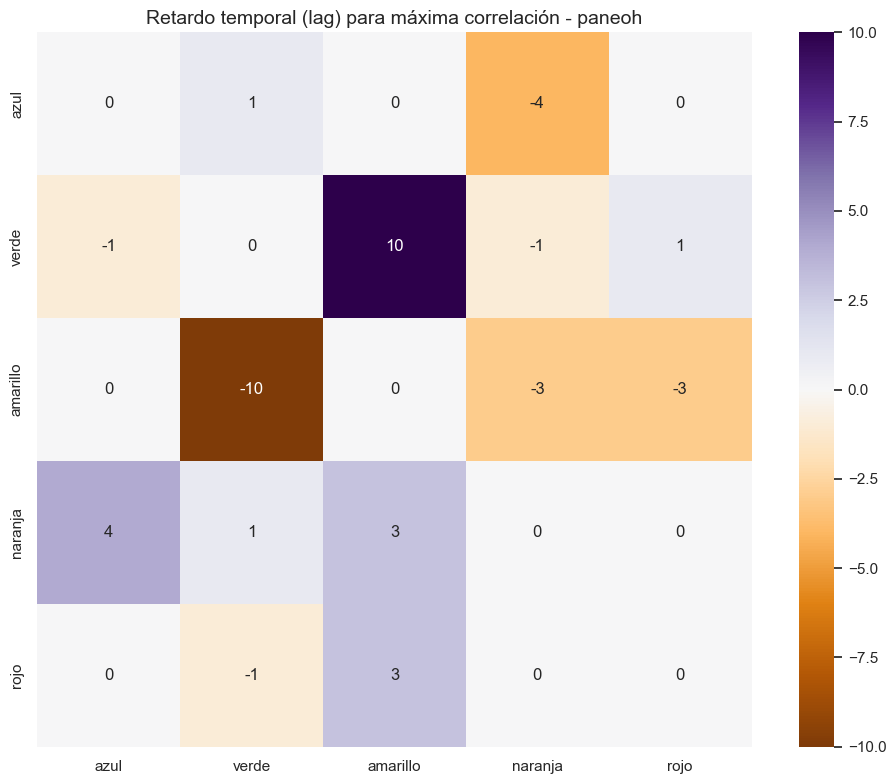

In [14]:
def generar_mapas_calor_por_archivo(archivo_csv, resolucion=100, guardar=False):
    """
    Genera mapas de calor detallados para un archivo de datos de fototransistores
    
    Args:
        archivo_csv: Ruta al archivo CSV con los datos
        resolucion: Resolución de la cuadrícula de interpolación (default=100)
        guardar: Si es True, guarda las imágenes en disco
    """
    print(f"Generando mapas de calor para {archivo_csv}...")
    
    # Cargar y procesar datos
    procesador = ProcesadorFototransistores(archivo_csv)
    df = procesador.obtener_dataframe_procesado()
    
    # Usar las posiciones de sensores definidas globalmente
    posiciones = POSICIONES_SENSORES
    
    # Crear cuadrícula para interpolación
    grid_x, grid_y = np.mgrid[0:1:resolucion*1j, 0:1:resolucion*1j]
    
    # Obtener nombre base para guardar archivos
    nombre_base = os.path.splitext(os.path.basename(archivo_csv))[0]
    
    # 1. Mapa de calor agregado (promedio de todo el experimento)
    # ------------------------------------------------------
    plt.figure(figsize=(10, 8))
    
    # Calcular valores promedio para cada sensor
    valores_promedio = [df[f'{sensor}_norm'].mean() for sensor in ORDEN_SENSORES]
    puntos = np.array([posiciones[sensor] for sensor in ORDEN_SENSORES])
    
    # Interpolar usando Radial Basis Function
    rbf = Rbf(puntos[:, 0], puntos[:, 1], valores_promedio, function='multiquadric')
    z_promedio = rbf(grid_x, grid_y)
    
    # Graficar el mapa de calor promedio
    plt.imshow(z_promedio.T, origin='lower', extent=[0, 1, 0, 1], 
              cmap='hot', vmin=0, vmax=1)
    plt.colorbar(label='Intensidad normalizada promedio')
    
    # Marcar posiciones de los sensores
    for i, sensor in enumerate(ORDEN_SENSORES):
        x, y = posiciones[sensor]
        valor = valores_promedio[i]
        plt.plot(x, y, 'o', markersize=10, 
               markerfacecolor='white', markeredgecolor='black')
        plt.text(x, y, f'{sensor}\n{valor:.2f}', ha='center', va='center', 
               fontsize=9, color='black', fontweight='bold',
               bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
    
    plt.title(f'Mapa de calor promedio - {nombre_base}', fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    
    if guardar:
        plt.savefig(f'{nombre_base}_mapa_calor_promedio.png', dpi=300)
    
    plt.show()
    
    # 2. Mapa de calor de varianza (muestra dónde hay más cambios)
    # ------------------------------------------------------
    plt.figure(figsize=(10, 8))
    
    # Calcular valores de varianza para cada sensor
    valores_varianza = [df[f'{sensor}_norm'].var() for sensor in ORDEN_SENSORES]
    # Normalizar valores de varianza para mejor visualización
    max_var = max(valores_varianza)
    if max_var > 0:
        valores_varianza = [v/max_var for v in valores_varianza]
    
    # Interpolar usando Radial Basis Function
    rbf = Rbf(puntos[:, 0], puntos[:, 1], valores_varianza, function='multiquadric')
    z_varianza = rbf(grid_x, grid_y)
    
    # Graficar el mapa de calor de varianza
    plt.imshow(z_varianza.T, origin='lower', extent=[0, 1, 0, 1], 
              cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Varianza normalizada')
    
    # Marcar posiciones de los sensores
    for i, sensor in enumerate(ORDEN_SENSORES):
        x, y = posiciones[sensor]
        valor = valores_varianza[i]
        plt.plot(x, y, 'o', markersize=10, 
               markerfacecolor='white', markeredgecolor='black')
        plt.text(x, y, f'{sensor}\n{valor:.2f}', ha='center', va='center', 
               fontsize=9, color='black', fontweight='bold',
               bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
    
    plt.title(f'Mapa de varianza - {nombre_base}', fontsize=14)
    plt.grid(False)
    plt.tight_layout()
    
    if guardar:
        plt.savefig(f'{nombre_base}_mapa_varianza.png', dpi=300)
    
    plt.show()
    
    # 3. Serie de mapas de calor en momentos clave
    # ------------------------------------------------------
    # Seleccionar frames equidistantes para mostrar la evolución
    num_frames = 6
    indices = np.linspace(0, len(df) - 1, num_frames, dtype=int)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        if i < len(axes):
            ax = axes[i]
            
            # Valores normalizados para este instante
            valores = [df.iloc[idx][f'{sensor}_norm'] for sensor in ORDEN_SENSORES]
            
            # Interpolar usando Radial Basis Function
            rbf = Rbf(puntos[:, 0], puntos[:, 1], valores, function='multiquadric')
            z = rbf(grid_x, grid_y)
            
            # Graficar el mapa de calor
            im = ax.imshow(z.T, origin='lower', extent=[0, 1, 0, 1], 
                          cmap='hot', vmin=0, vmax=1)
            
            # Marcar posiciones de los sensores
            for j, sensor in enumerate(ORDEN_SENSORES):
                x, y = posiciones[sensor]
                valor = valores[j]
                ax.plot(x, y, 'o', markersize=8, 
                       markerfacecolor='white', markeredgecolor='black')
                ax.text(x, y, f'{valor:.2f}', ha='center', va='center', 
                       fontsize=8, color='black', fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
            
            ax.set_title(f't = {df.iloc[idx]["tiempo"]:.2f}s')
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Añadir una barra de color
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Intensidad normalizada')
    
    plt.suptitle(f'Evolución de la distribución de luz - {nombre_base}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    if guardar:
        plt.savefig(f'{nombre_base}_mapas_evolucion.png', dpi=300)
    
    plt.show()
    
    # 4. Mapa de calor 3D (superficie)
    # ------------------------------------------------------
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Crear datos para la superficie 3D
    X = grid_x
    Y = grid_y
    Z = z_promedio
    
    # Graficar superficie
    surf = ax.plot_surface(X, Y, Z, cmap='hot', 
                          linewidth=0, antialiased=True, alpha=0.8)
    
    # Añadir puntos de los sensores
    for i, sensor in enumerate(ORDEN_SENSORES):
        x, y = posiciones[sensor]
        valor = valores_promedio[i]
        ax.scatter([x], [y], [valor], c='white', s=100, edgecolor='black')
        ax.text(x, y, valor + 0.05, f'{sensor}: {valor:.2f}', 
               fontsize=9, ha='center')
    
    # Configurar gráfico
    ax.set_title(f'Superficie 3D de intensidad promedio - {nombre_base}', fontsize=14)
    ax.set_xlabel('Posición X')
    ax.set_ylabel('Posición Y')
    ax.set_zlabel('Intensidad normalizada')
    ax.set_zlim(0, 1.2)
    
    # Añadir barra de color
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Intensidad normalizada')
    
    plt.tight_layout()
    
    if guardar:
        plt.savefig(f'{nombre_base}_mapa_3d.png', dpi=300)
    
    plt.show()
    
    # 5. Heatmap de correlación temporal entre sensores
    # ------------------------------------------------------
    plt.figure(figsize=(10, 8))
    
    # Calcular matriz de correlación con retardo temporal
    max_lag = 10  # Máximo retardo temporal a considerar
    sensores = ORDEN_SENSORES
    num_sensores = len(sensores)
    
    # Matriz para almacenar correlaciones máximas y sus retardos
    corr_max = np.zeros((num_sensores, num_sensores))
    lag_max = np.zeros((num_sensores, num_sensores))
    
    for i, sensor1 in enumerate(sensores):
        for j, sensor2 in enumerate(sensores):
            if i == j:
                corr_max[i, j] = 1.0
                lag_max[i, j] = 0
            else:
                # Calcular correlación cruzada
                corrs = []
                for lag in range(-max_lag, max_lag + 1):
                    if lag < 0:
                        s1 = df[f'{sensor1}_norm'].iloc[:lag]
                        s2 = df[f'{sensor2}_norm'].iloc[-lag:]
                    elif lag > 0:
                        s1 = df[f'{sensor1}_norm'].iloc[lag:]
                        s2 = df[f'{sensor2}_norm'].iloc[:-lag]
                    else:  # lag == 0
                        s1 = df[f'{sensor1}_norm']
                        s2 = df[f'{sensor2}_norm']
                    
                    if len(s1) > 10:  # Asegurar suficientes datos
                        corr = np.corrcoef(s1, s2)[0, 1]
                        corrs.append((lag, corr))
                
                if corrs:
                    # Encontrar máxima correlación y su retardo
                    max_corr_idx = np.argmax([abs(c[1]) for c in corrs])
                    lag_max[i, j] = corrs[max_corr_idx][0]
                    corr_max[i, j] = corrs[max_corr_idx][1]
    
    # Graficar mapa de calor de correlaciones máximas
    sns.heatmap(corr_max, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                square=True, xticklabels=sensores, yticklabels=sensores)
    plt.title(f'Correlación temporal máxima entre sensores - {nombre_base}', fontsize=14)
    plt.tight_layout()
    
    if guardar:
        plt.savefig(f'{nombre_base}_correlacion_temporal.png', dpi=300)
    
    plt.show()
    
    # Graficar mapa de calor de retardos temporales
    plt.figure(figsize=(10, 8))
    sns.heatmap(lag_max, annot=True, cmap='PuOr', center=0, 
                square=True, xticklabels=sensores, yticklabels=sensores)
    plt.title(f'Retardo temporal (lag) para máxima correlación - {nombre_base}', fontsize=14)
    plt.tight_layout()
    
    if guardar:
        plt.savefig(f'{nombre_base}_retardo_temporal.png', dpi=300)
    
    plt.show()
    
    return

def generar_todos_mapas_calor(guardar=False):
    """
    Genera mapas de calor para todos los archivos CSV disponibles
    
    Args:
        guardar: Si es True, guarda las imágenes en disco
    """
    archivos_csv = listar_csv()
    
    if not archivos_csv:
        print("No se encontraron archivos CSV para analizar")
        return
    
    for archivo in archivos_csv:
        generar_mapas_calor_por_archivo(archivo, guardar=guardar)

# Generar mapas de calor para un archivo de ejemplo
if archivos_csv:
    print(f"Generando mapa de calor para {archivos_csv[0]} como ejemplo...")
    generar_mapas_calor_por_archivo(archivos_csv[0])
    
    # Comentar la siguiente línea si quieres generar mapas para todos los archivos
    # print("\nPara generar mapas de calor para todos los archivos, ejecuta: generar_todos_mapas_calor()")

Comparando mapas de calor entre archivos...
Hay 8 archivos. Limitando la comparación a 6 archivos.
Se adaptaron los nombres de columnas para aaaaaaaaaaaa.csv
Se adaptaron los nombres de columnas para aaaaaaaaaaaa.csv


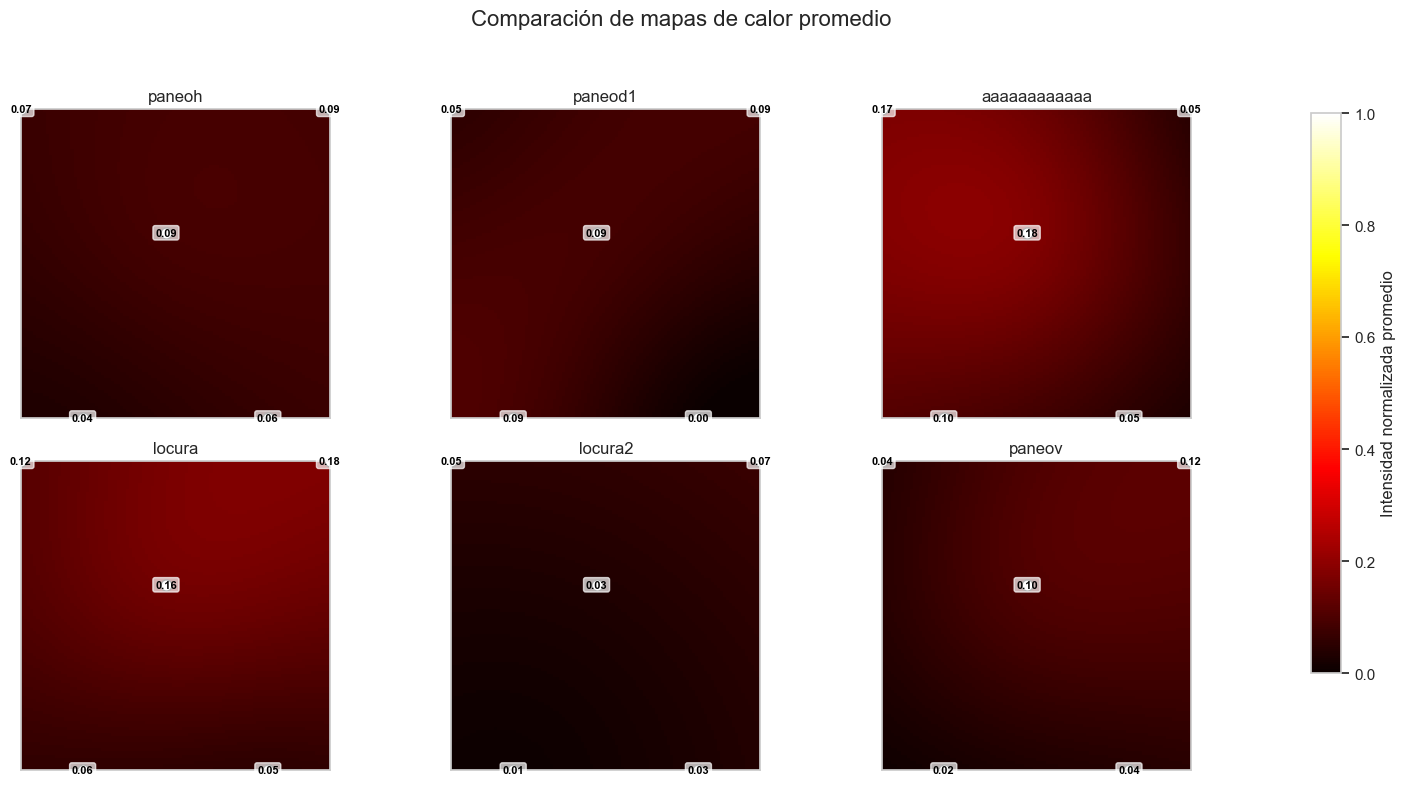

Se adaptaron los nombres de columnas para aaaaaaaaaaaa.csv
Se adaptaron los nombres de columnas para aaaaaaaaaaaa.csv


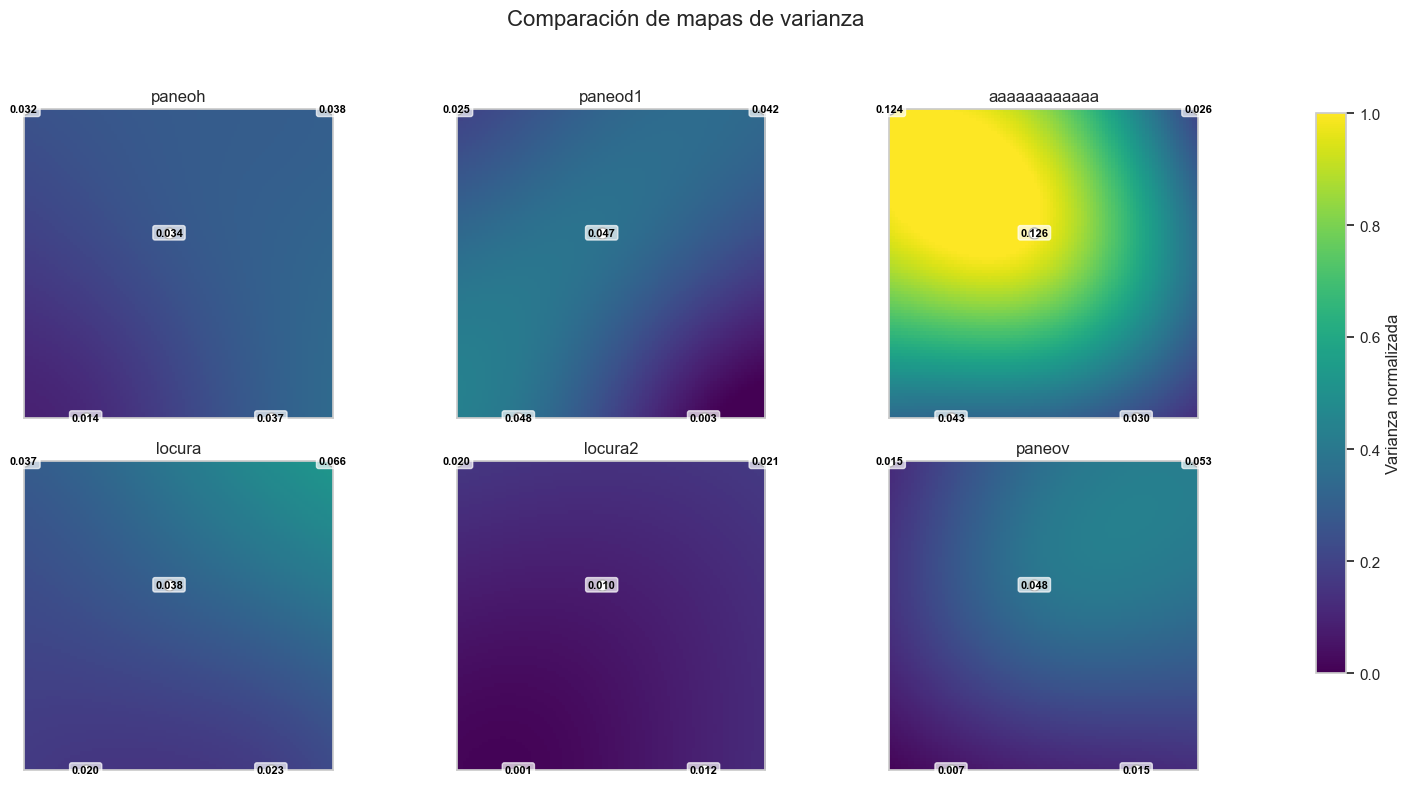

Se adaptaron los nombres de columnas para aaaaaaaaaaaa.csv


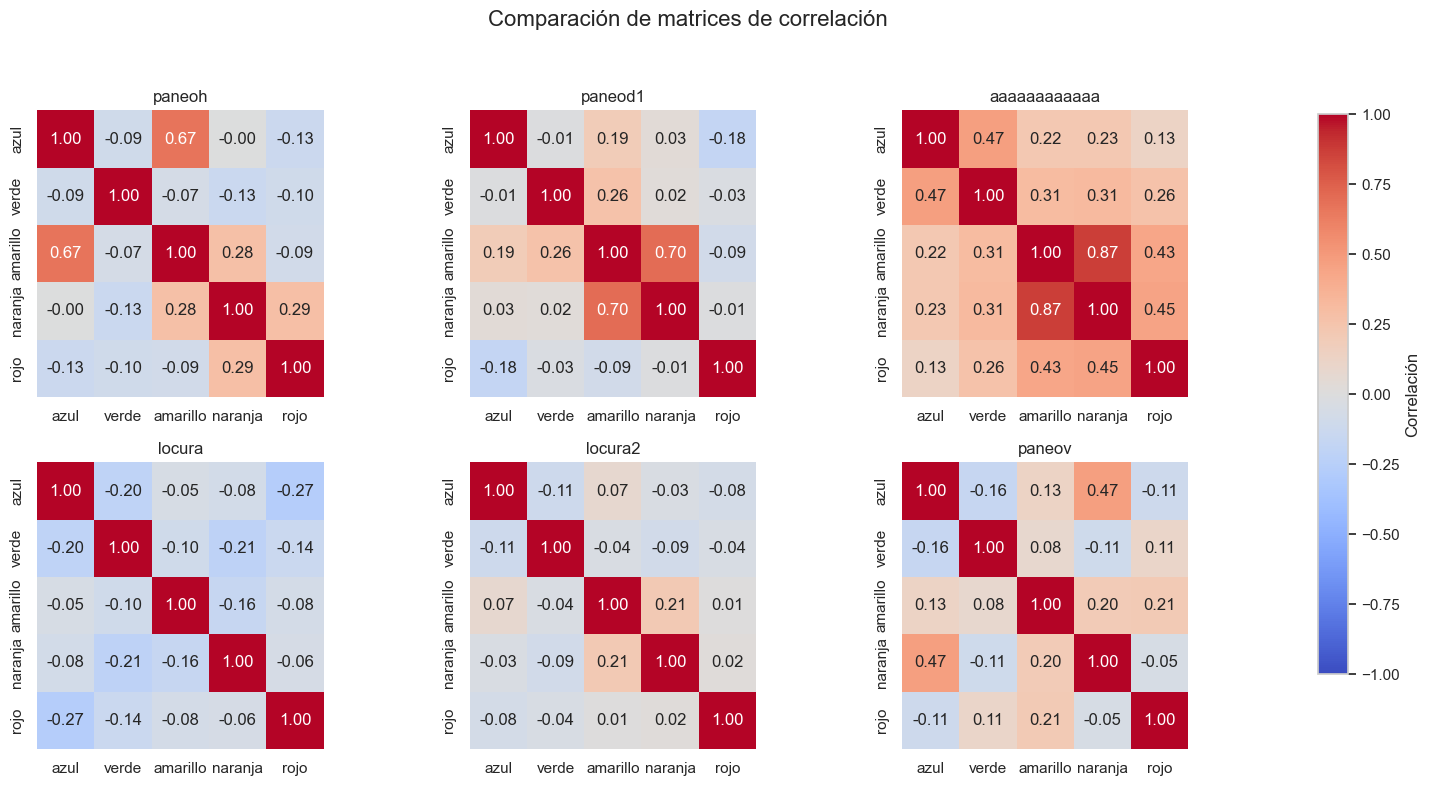

In [15]:
def comparar_mapas_calor_archivos(archivos_seleccionados=None):
    """
    Compara los mapas de calor promedio entre diferentes archivos
    
    Args:
        archivos_seleccionados: Lista de archivos a comparar. Si es None, usa todos los disponibles.
    """
    # Obtener lista de archivos
    todos_archivos = listar_csv()
    
    if not todos_archivos:
        print("No se encontraron archivos CSV para analizar")
        return
    
    # Seleccionar archivos a comparar
    if archivos_seleccionados is None:
        # Si hay muchos archivos, limitar a un máximo de 6
        if len(todos_archivos) > 6:
            print(f"Hay {len(todos_archivos)} archivos. Limitando la comparación a 6 archivos.")
            archivos = todos_archivos[:6]
        else:
            archivos = todos_archivos
    else:
        # Verificar que los archivos seleccionados existen
        archivos = [a for a in archivos_seleccionados if a in todos_archivos]
        if not archivos:
            print("Ninguno de los archivos seleccionados está disponible.")
            return
    
    # Determinar el layout de la cuadrícula para los subplots
    n = len(archivos)
    if n <= 3:
        nrows, ncols = 1, n
    elif n <= 6:
        nrows, ncols = 2, 3
    else:
        nrows, ncols = (n + 3) // 4, 4
    
    # Usar las posiciones de sensores definidas globalmente
    posiciones = POSICIONES_SENSORES
    sensores_orden = ORDEN_SENSORES
    
    # Crear cuadrícula para interpolación
    resolucion = 100
    grid_x, grid_y = np.mgrid[0:1:resolucion*1j, 0:1:resolucion*1j]
    puntos = np.array([posiciones[sensor] for sensor in sensores_orden])
    
    # 1. Comparación de mapas de calor promedio
    # ------------------------------------------
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    if n == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Establecer límites comunes para los colores
    vmin, vmax = 0, 1
    
    for i, archivo in enumerate(archivos):
        if i < len(axes):
            ax = axes[i]
            
            # Cargar datos
            procesador = ProcesadorFototransistores(archivo)
            df = procesador.obtener_dataframe_procesado()
            
            # Calcular valores promedio para cada sensor
            valores_promedio = [df[f'{sensor}_norm'].mean() for sensor in sensores_orden]
            
            # Interpolar usando Radial Basis Function
            rbf = Rbf(puntos[:, 0], puntos[:, 1], valores_promedio, function='multiquadric')
            z_promedio = rbf(grid_x, grid_y)
            
            # Graficar el mapa de calor promedio
            im = ax.imshow(z_promedio.T, origin='lower', extent=[0, 1, 0, 1], 
                          cmap='hot', vmin=vmin, vmax=vmax)
            
            # Marcar posiciones de los sensores
            for j, sensor in enumerate(sensores_orden):
                x, y = posiciones[sensor]
                valor = valores_promedio[j]
                ax.plot(x, y, 'o', markersize=8, 
                       markerfacecolor='white', markeredgecolor='black')
                ax.text(x, y, f'{valor:.2f}', ha='center', va='center', 
                       fontsize=8, color='black', fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
            
            nombre_base = os.path.splitext(os.path.basename(archivo))[0]
            ax.set_title(f'{nombre_base}')
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Ocultar ejes vacíos
    for i in range(len(archivos), len(axes)):
        axes[i].axis('off')
    
    # Añadir una barra de color común
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Intensidad normalizada promedio')
    
    plt.suptitle('Comparación de mapas de calor promedio', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()
    
    # 2. Comparación de mapas de varianza
    # ------------------------------------------
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    if n == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Recopilar valores de varianza máxima para escala común
    varianzas_max = []
    for archivo in archivos:
        procesador = ProcesadorFototransistores(archivo)
        df = procesador.obtener_dataframe_procesado()
        valores_varianza = [df[f'{sensor}_norm'].var() for sensor in sensores_orden]
        varianzas_max.append(max(valores_varianza))
    
    # Establecer escala común
    var_max_global = max(varianzas_max) if varianzas_max else 1.0
    
    for i, archivo in enumerate(archivos):
        if i < len(axes):
            ax = axes[i]
            
            # Cargar datos
            procesador = ProcesadorFototransistores(archivo)
            df = procesador.obtener_dataframe_procesado()
            
            # Calcular valores de varianza para cada sensor
            valores_varianza = [df[f'{sensor}_norm'].var() for sensor in sensores_orden]
            # Normalizar valores de varianza para mejor visualización
            valores_varianza_norm = [v/var_max_global for v in valores_varianza]
            
            # Interpolar usando Radial Basis Function
            rbf = Rbf(puntos[:, 0], puntos[:, 1], valores_varianza_norm, function='multiquadric')
            z_varianza = rbf(grid_x, grid_y)
            
            # Graficar el mapa de calor de varianza
            im = ax.imshow(z_varianza.T, origin='lower', extent=[0, 1, 0, 1], 
                          cmap='viridis', vmin=0, vmax=1)
            
            # Marcar posiciones de los sensores
            for j, sensor in enumerate(sensores_orden):
                x, y = posiciones[sensor]
                valor_norm = valores_varianza_norm[j]
                valor_real = valores_varianza[j]
                ax.plot(x, y, 'o', markersize=8, 
                       markerfacecolor='white', markeredgecolor='black')
                ax.text(x, y, f'{valor_real:.3f}', ha='center', va='center', 
                       fontsize=8, color='black', fontweight='bold',
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
            
            nombre_base = os.path.splitext(os.path.basename(archivo))[0]
            ax.set_title(f'{nombre_base}')
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Ocultar ejes vacíos
    for i in range(len(archivos), len(axes)):
        axes[i].axis('off')
    
    # Añadir una barra de color común
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label='Varianza normalizada')
    
    plt.suptitle('Comparación de mapas de varianza', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()
    
    # 3. Comparación de patrones de correlación
    # ------------------------------------------
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4))
    if n == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, archivo in enumerate(archivos):
        if i < len(axes):
            ax = axes[i]
            
            # Cargar datos
            procesador = ProcesadorFototransistores(archivo)
            df = procesador.obtener_dataframe_procesado()
            
            # Calcular matriz de correlación
            sensores = sensores_orden
            matriz_corr = df[[f'{s}_norm' for s in sensores]].corr()
            
            # Graficar mapa de calor de correlación
            sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
                        square=True, cbar=False, ax=ax, fmt='.2f',
                        xticklabels=sensores, yticklabels=sensores)
            
            nombre_base = os.path.splitext(os.path.basename(archivo))[0]
            ax.set_title(f'{nombre_base}')
    
    # Ocultar ejes vacíos
    for i in range(len(archivos), len(axes)):
        axes[i].axis('off')
    
    # Añadir una barra de color común
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(-1, 1))
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax, label='Correlación')
    
    plt.suptitle('Comparación de matrices de correlación', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()
    
    return

# Ejecutar la comparación si hay al menos dos archivos
if len(archivos_csv) >= 2:
    print("Comparando mapas de calor entre archivos...")
    comparar_mapas_calor_archivos()
else:
    print("Se necesitan al menos dos archivos CSV para comparar mapas de calor.")

## 14. Interpretación de los Mapas de Calor

Los mapas de calor generados proporcionan una representación visual poderosa de los datos de los fototransistores:

1. **Mapas de calor promedio**: Muestran la distribución promedio de intensidad luminosa durante todo el experimento. Las áreas más brillantes indican mayor intensidad media.

2. **Mapas de varianza**: Revelan dónde ocurrieron los mayores cambios de intensidad. Las áreas con alta varianza indican regiones donde la luz fluctuó significativamente.

3. **Evolución temporal**: Las series de mapas muestran cómo cambió la distribución de luz a lo largo del tiempo, permitiendo identificar patrones de movimiento.

4. **Representación 3D**: Proporciona una visualización intuitiva de la distribución de intensidad en forma de superficie.

5. **Correlación temporal**: Muestra cómo se relacionan los cambios entre diferentes sensores y con qué retardo temporal, lo que ayuda a identificar la dirección del movimiento.

### Interpretación según el patrón de movimiento:

- **Movimiento Horizontal (paneoh.csv)**: El mapa de calor muestra mayor intensidad a lo largo del eje X, con alta correlación entre sensores de la misma fila.

- **Movimiento Vertical (paneov.csv)**: El mapa de calor muestra mayor intensidad a lo largo del eje Y, con alta correlación entre sensores de la misma columna.

- **Movimiento Diagonal/Circular (paneod1.csv)**: El mapa de calor muestra patrones diagonales o circulares, con correlaciones complejas entre sensores.

- **Movimiento Aleatorio (locura.csv, locura2.csv)**: Los mapas de calor muestran patrones irregulares sin una dirección clara, con correlaciones débiles entre sensores.

Estos mapas de calor complementan el análisis estadístico y las visualizaciones de trayectoria, proporcionando una representación espacial de los datos que facilita la identificación visual de patrones.

## 14. Resumen de Correcciones Implementadas

En esta versión del notebook se realizaron las siguientes correcciones:

1. **Configuración correcta de las posiciones de los sensores**: Se actualizó la distribución espacial de los sensores para reflejar su posición real en la protoboard:
   - Azul: (0.1, 0.1) - Esquina superior izquierda
   - Verde: (0.9, 0.1) - Esquina superior derecha
   - Amarillo: (0.5, 0.5) - Centro
   - Naranja: (0.1, 0.9) - Esquina inferior izquierda
   - Rojo: (0.9, 0.9) - Esquina inferior derecha

2. **Visualización de la configuración**: Se añadió una visualización clara de la distribución de los sensores al inicio del notebook para facilitar la comprensión.

3. **Variables globales**: Se definieron las posiciones y el orden de los sensores como variables globales para mantener la consistencia en todo el análisis.

4. **Corrección en los mapas de calor**: Se actualizaron las funciones de generación de mapas de calor para utilizar las posiciones correctas.

5. **Corrección en la visualización espaciotemporal**: Se modificó la función de evolución espaciotemporal para utilizar las coordenadas correctas de los sensores.

Estas correcciones aseguran que todos los análisis espaciales y visualizaciones reflejen con precisión la disposición física de los sensores, mejorando la interpretación de los resultados.

Comparando trayectorias entre archivos...
Hay 8 archivos. Limitando la comparación a 6 archivos.
Se adaptaron los nombres de columnas para aaaaaaaaaaaa.csv


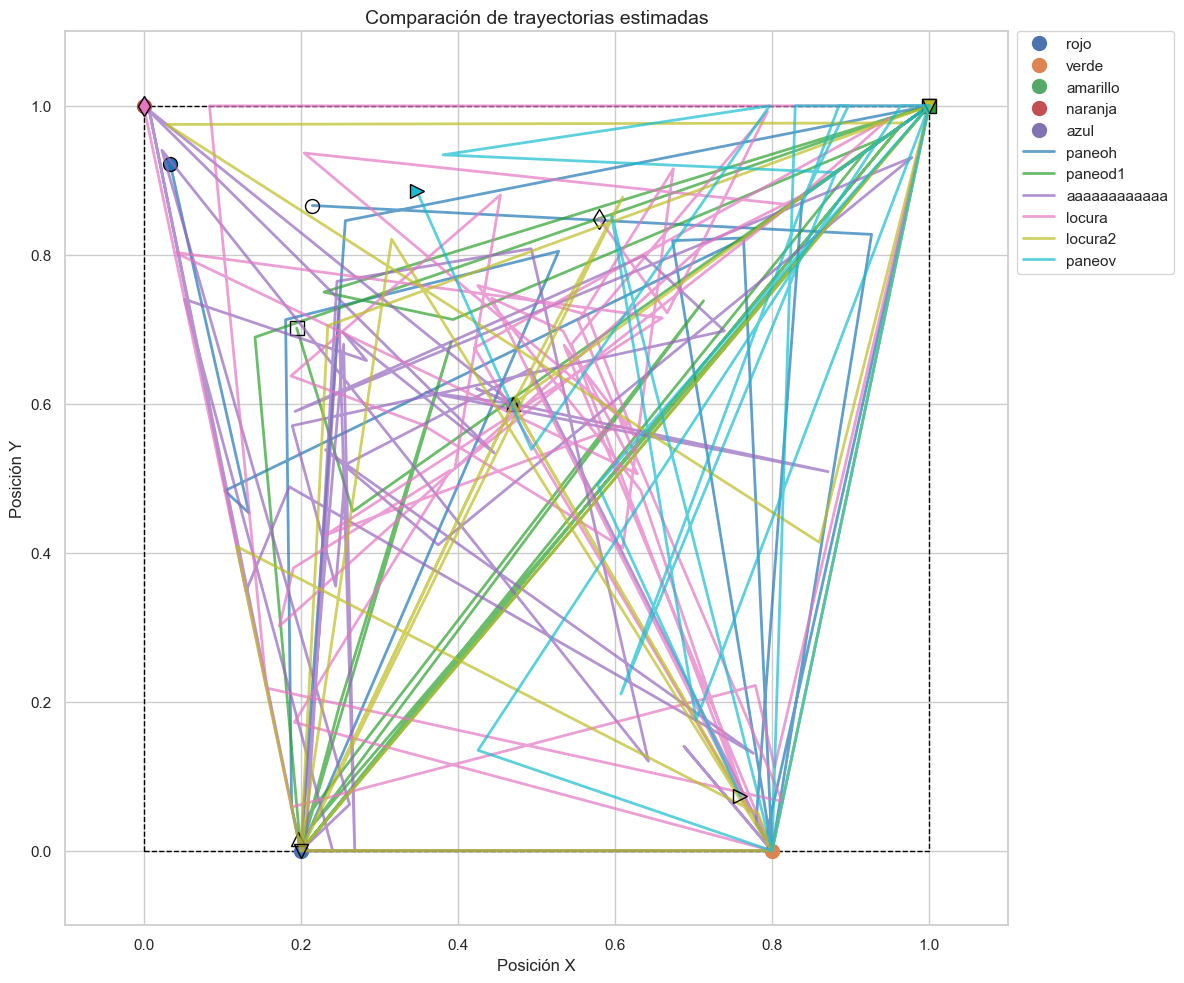

In [16]:
def comparar_trayectorias(archivos_seleccionados=None, num_frames=None):
    """
    Compara las trayectorias estimadas entre diferentes archivos en un solo gráfico.
    
    Args:
        archivos_seleccionados: Lista de archivos a comparar. Si es None, usa todos los disponibles.
        num_frames: Número de puntos a mostrar por trayectoria. Si es None, usa todos.
    """
    # Obtener lista de archivos
    todos_archivos = listar_csv()
    
    if not todos_archivos:
        print("No se encontraron archivos CSV para analizar")
        return
    
    # Seleccionar archivos a comparar
    if archivos_seleccionados is None:
        # Si hay muchos archivos, limitar a un máximo de 6 para claridad
        if len(todos_archivos) > 6:
            print(f"Hay {len(todos_archivos)} archivos. Limitando la comparación a 6 archivos.")
            archivos = todos_archivos[:6]
        else:
            archivos = todos_archivos
    else:
        # Verificar que los archivos seleccionados existen
        archivos = [a for a in archivos_seleccionados if a in todos_archivos]
        if not archivos:
            print("Ninguno de los archivos seleccionados está disponible.")
            return
    
    # Usar las posiciones de sensores definidas globalmente
    posiciones = POSICIONES_SENSORES
    sensores_orden = ORDEN_SENSORES
    
    # Crear figura para comparación de trayectorias
    plt.figure(figsize=(12, 10))
    
    # Dibujar los límites de la protoboard
    rect = plt.Rectangle((0, 0), 1, 1, fill=False, edgecolor='black', linestyle='--')
    plt.gca().add_patch(rect)
    
    # Dibujar los sensores
    for sensor, (x, y) in posiciones.items():
        plt.plot(x, y, 'o', markersize=10, label=sensor)
    
    # Colores y marcadores para diferentes trayectorias
    colores = plt.cm.tab10(np.linspace(0, 1, len(archivos)))
    marcadores = ['o', 's', '^', 'd', 'v', '>', '<', 'p']
    
    # Procesar cada archivo y dibujar su trayectoria
    for i, archivo in enumerate(archivos):
        color = colores[i]
        marcador = marcadores[i % len(marcadores)]
        nombre_base = os.path.splitext(os.path.basename(archivo))[0]
        
        # Cargar y procesar datos
        procesador = ProcesadorFototransistores(archivo)
        df = procesador.obtener_dataframe_procesado()
        
        # Seleccionar frames si se especifica
        if num_frames is not None and num_frames < len(df):
            indices = np.linspace(0, len(df) - 1, num_frames, dtype=int)
            df_vis = df.iloc[indices].copy()
        else:
            df_vis = df.copy()
        
        # Calcular la trayectoria estimada
        trayectoria_x = []
        trayectoria_y = []
        
        for idx, row in df_vis.iterrows():
            # Calcular posición ponderada por intensidad normalizada
            suma_pesos = 0
            pos_x = 0
            pos_y = 0
            
            for sensor in sensores_orden:
                x, y = posiciones[sensor]
                peso = row[f'{sensor}_norm']
                pos_x += x * peso
                pos_y += y * peso
                suma_pesos += peso
            
            if suma_pesos > 0:
                trayectoria_x.append(pos_x / suma_pesos)
                trayectoria_y.append(pos_y / suma_pesos)
        
        # Dibujar la trayectoria
        plt.plot(trayectoria_x, trayectoria_y, '-', color=color, alpha=0.7, 
                linewidth=2, label=f'Trayectoria {nombre_base}')
        
        # Marcar puntos iniciales y finales
        if trayectoria_x and trayectoria_y:
            plt.plot(trayectoria_x[0], trayectoria_y[0], marcador, color=color, 
                    markersize=10, markeredgecolor='black', 
                    label=f'Inicio {nombre_base}')
            plt.plot(trayectoria_x[-1], trayectoria_y[-1], marcador, color=color, 
                    markersize=10, markeredgecolor='black', markerfacecolor='none', 
                    label=f'Fin {nombre_base}')
    
    # Configurar gráfico
    plt.title('Comparación de trayectorias estimadas', fontsize=14)
    plt.xlabel('Posición X')
    plt.ylabel('Posición Y')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.grid(True)
    
    # Crear leyenda optimizada (para evitar duplicados de sensores)
    handles, labels = plt.gca().get_legend_handles_labels()
    # Primero mostrar los sensores
    sensor_handles = handles[:len(sensores_orden)]
    sensor_labels = labels[:len(sensores_orden)]
    # Luego mostrar las trayectorias agrupadas por archivo
    handles_trayectoria = []
    labels_trayectoria = []
    for i, archivo in enumerate(archivos):
        nombre_base = os.path.splitext(os.path.basename(archivo))[0]
        idx = labels.index(f'Trayectoria {nombre_base}')
        handles_trayectoria.append(handles[idx])
        labels_trayectoria.append(nombre_base)
    
    plt.legend(sensor_handles + handles_trayectoria, 
              sensor_labels + labels_trayectoria, 
              loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
    
    plt.tight_layout()
    plt.show()
    
    return

# Ejecutar la comparación de trayectorias si hay múltiples archivos
if len(archivos_csv) > 1:
    print("Comparando trayectorias entre archivos...")
    comparar_trayectorias(num_frames=50)  # Usar 50 puntos por trayectoria para claridad
else:
    print("Se necesitan al menos dos archivos CSV para comparar trayectorias.")

## 15. Resumen Final y Próximos Pasos

Este notebook ahora proporciona un análisis completo de los datos de fototransistores con la configuración correcta de posiciones de los sensores:

### Funcionalidades implementadas:

1. **Carga y preprocesamiento de datos**: Normalización, filtrado y detección de eventos.
2. **Visualización de señales**: Gráficos temporales y correlaciones entre sensores.
3. **Análisis espacio-temporal**: Visualización animada y estática de la evolución de la luz.
4. **Mapas de calor**: Representación espacial de la intensidad de luz y su variación.
5. **Detección de patrones**: Identificación automática del tipo de movimiento (horizontal, vertical, circular, etc.).
6. **Análisis comparativo**: Comparación entre múltiples archivos para diferentes patrones de movimiento.
7. **Trayectorias comparativas**: Visualización conjunta de las trayectorias de diferentes experimentos.

### Posibles mejoras futuras:

1. **Calibración automática**: Implementar un proceso para calibrar automáticamente la sensibilidad de los sensores.
2. **Clasificación avanzada**: Utilizar algoritmos de aprendizaje automático para clasificar con mayor precisión los patrones de movimiento.
3. **Detección de gestos**: Extender el análisis para reconocer gestos específicos basados en patrones de movimiento.
4. **Interfaz interactiva**: Desarrollar widgets interactivos para explorar los datos de forma dinámica.
5. **Exportación de modelos**: Crear funciones para exportar modelos entrenados que puedan usarse en dispositivos embebidos.

### Instrucciones de uso:

1. Coloca los archivos CSV en el mismo directorio que este notebook.
2. Ejecuta todas las celdas para procesar los archivos disponibles.
3. Utiliza las funciones específicas para analizar archivos individuales o comparar múltiples archivos.
4. Los resultados de los análisis se pueden exportar a archivos CSV o guardar como imágenes.